# Bed-in-a-box: what's the consumer perspective?
It's pretty important to find the right mattress since we're sleeping on them nightly. I read somewhere that some large proportion of people trust reviews just as much as they trust personal recommendations. Since this whole COVID disaster shut down businesses, it's really important to make sure we're buying a quality product without trying it out. I found [this website](https://www.which.co.uk/reviews/mattresses/article/top-bed-in-a-box-mattresses) that summarizes the "best" bed-in-a-box companies, but I needed to look at some reviews from others. The Trustpilot website states that they have 1.1 trillion ratings across 300,000 businesses. This is impressive, but unfortunately I don't have that much time, even in lockdown.

So here we're going to look at reviews of those best companies and try and figure out if there's a stand-out winner. We begin with scraping the trustpilot website. I followed this tutorial [here](https://www.dataquest.io/blog/web-scraping-beautifulsoup/), which was amazing to help write the code.

# Scraping trustpilot with BeautifulSoup

Let's start by figuring out how to access the right information. I went to the trustpilot website and looked at the html code of the parts I'm interested in. We'll begin with Emma.

In [140]:
from requests import get
from bs4 import BeautifulSoup
url = 'https://www.trustpilot.com/review/www.emma-mattress.co.uk?languages=all&page=1'
response = get(url)

In [2]:
html_soup = BeautifulSoup(response.text, 'html.parser')
#we start with the user details
user_containers = html_soup.find_all('div', class_ = 'consumer-information__name')
print(type(user_containers))
print(len(user_containers))

<class 'bs4.element.ResultSet'>
20


In [3]:
first = user_containers[0]
first.text

'\n            Sharon Druce\n        '

In [4]:
# let's look for the review content
review_containers = html_soup.find_all('div', class_ = 'review-content__body')
print(type(review_containers))
print(len(review_containers))

<class 'bs4.element.ResultSet'>
20


In [5]:
first_rev= review_containers[0]
first_rev

<div class="review-content__body" v-pre="">
<h2 class="review-content__title">
<a class="link link--large link--dark" data-track-link="{'target': 'Single review', 'name': 'review-title'}" href="/reviews/5f52205b02e85708c8dfc5eb">Ok I’ve now had my Emma mattress for a…</a>
</h2>
<p class="review-content__text">
                Ok I’ve now had my Emma mattress for a few months, it’s ok apart from the materials in it causes me to sweat , I thought it had a cooling layer to regulate body temperature, but if I get out during the night the matress actually feels damp and sweaty when I get back in bed,I’ve now removed the mattress protector but there’s no difference . I’ve been putting a bath sheet towel on to lay on , I’ve not even attempted to use the pillow it’s about an inch thick and rock hard so it’s a no no for me, I think I will be returning after the 200 days are up , I’m off to Dreams . I haven’t actually had a good solid nights sleep throughout .
            </p>
</div>

Looks like we can collect the title and review from here.

In [6]:
title = first_rev.h2.a.text
review = first_rev.p.text
print(title)
print(review)

Ok I’ve now had my Emma mattress for a…

                Ok I’ve now had my Emma mattress for a few months, it’s ok apart from the materials in it causes me to sweat , I thought it had a cooling layer to regulate body temperature, but if I get out during the night the matress actually feels damp and sweaty when I get back in bed,I’ve now removed the mattress protector but there’s no difference . I’ve been putting a bath sheet towel on to lay on , I’ve not even attempted to use the pillow it’s about an inch thick and rock hard so it’s a no no for me, I think I will be returning after the 200 days are up , I’m off to Dreams . I haven’t actually had a good solid nights sleep throughout .
            


Would also like to collect the rating, so let's sort that out.

In [7]:
rating_container = html_soup.find_all('div',class_ = "star-rating star-rating--medium")
first_rating = rating_container[0]
first_rating

<div class="star-rating star-rating--medium">
<img alt="1 star: Bad" src="https://cdn.trustpilot.net/brand-assets/4.1.0/stars/stars-1.svg"/>
</div>

In [8]:
stars = first_rating.img['alt'][0]
stars

'1'

Cool, we can just select the first letter of the string since it's in the format '1 star: Bad'. Now onto the dates.

In [9]:
dates_container = html_soup.find_all('div',class_ = "review-content-header__dates")
first_date = dates_container[0]
first_date

<div class="review-content-header__dates">
<script data-initial-state="review-dates" type="application/json">
{"publishedDate":"2020-09-04T11:09:15Z","updatedDate":null,"reportedDate":null}
</script>
<review-dates :published-date="publishedDate" :reported-date="reportedDate" :updated-date="updatedDate"></review-dates>
</div>

In [10]:
date = first_date.script
date

<script data-initial-state="review-dates" type="application/json">
{"publishedDate":"2020-09-04T11:09:15Z","updatedDate":null,"reportedDate":null}
</script>

In [11]:
import re
date = str(date)
print(date)
result = re.search('publishedDate":(.*),"updatedDate"', date)
print(result.group(1)[1:11])


<script data-initial-state="review-dates" type="application/json">
{"publishedDate":"2020-09-04T11:09:15Z","updatedDate":null,"reportedDate":null}
</script>
2020-09-04


There might be a better way to get the date, but this seems to be an ok workaround, let's see if it scales (update: it did).

One last thing is to get the link to the poster location so we can see where people are from. We'll collect the user ID and then add this to the base address.

In [12]:
profile_link_containers = html_soup.find_all('div', class_ = "review-card")
first_profile = profile_link_containers[0].aside.a['href']
first_profile

'/users/5b22bbab4de5666d34749b69'

Alright, I think that's everything we need so I'm going to define a function tying it all together.

In [120]:
from time import sleep
from random import randint
import re
from requests import get
import pandas as pd
from IPython.core.display import clear_output
from time import time

# we'll do this with a function in case we want to add different companies to the analysis later
def scrape_reviews(PATH, n_pages):
    
    requests = 0
    
    #data we collect will be stored in lists
    names = []
    ratings = []
    headers = []
    reviews = []
    dates = []
    locations = []
    
    for p in range(n_pages):
        start_time = time()
        # sleep time to pause the loop between page collections, I had this shorter, but the host disrupted the collection, I guess it looked like a bot.
        sleep(randint(8,13))
        
        # make a get request
        response = get(f'{PATH}{p}')
        
        # Monitor the requests
        requests += 1
        elapsed_time = time() - start_time
        print('Request:{}; Frequency: {} requests/s'.format(requests, requests/elapsed_time))
        clear_output(wait = True)

        
        # Parse the content with BSoup
        page_html = BeautifulSoup(response.text, 'html.parser')
        
        # Select all of the relevant containers from a page
        review_containers = page_html.find_all('div', class_ = 'review-content__body')
        user_containers = page_html.find_all('div', class_ = 'consumer-information__name')
        rating_container = page_html.find_all('div',class_ = "star-rating star-rating--medium")
        date_container = page_html.find_all('div',class_ = "review-content-header__dates")
        profile_link_containers = page_html.find_all('div', class_ = "review-card")
        
        # now we start populating our lists
        for x in range(len(review_containers)):

            review_c = review_containers[x]
            #here we need to account for cases where reviews have been reported and return nothing. This happens when reviews are reported. Also those reviews that have a title, but no text in the review need to be accounted for.
            if review_c is None:
                headers.append('None')
                reviews.append('None')
            if review_c.p is None:
                reviews.append('None')
            else:
                reviews.append(review_c.p.text)
                headers.append(review_c.h2.a.text)
                
            reviewer = user_containers[x]
            names.append(reviewer.text)
            rating = rating_container[x]
            ratings.append(rating.img['alt'][0])
            date = date_container[x].script
            date = str(date)
            result = re.search('publishedDate":(.*),"updatedDate"', date)
            dates.append(result.group(1)[1:11])


            prof = profile_link_containers[x]
            link = 'https://www.trustpilot.com'+ prof.aside.a['href']
            c_profile = get(f'{link}')
            csoup = BeautifulSoup(c_profile.text, 'html.parser')
            cust_container = csoup.find('div', class_ = 'user-summary-location')
            #some people apparently don't specify a location, an error was raised in testing, so we'll make sure it still works in that case
            if cust_container is None:
                locations.append('None')
            else:
                locations.append(cust_container.text)
            
    rev_df = pd.DataFrame(list(zip(headers, reviews, ratings, names, locations, dates)),
                  columns = ['Header','Review','Rating', 'Name', 'Location', 'Date'])
    
    rev_df['Review'] = rev_df['Review'].str.replace('\n', '')
    rev_df['Name'] = rev_df['Name'].str.replace('\n', '')
    rev_df['Location'] = rev_df['Location'].str.replace('\n', '')    
    rev_df['Date'] = pd.to_datetime(rev_df['Date'])
    
    return rev_df



Trustpilot shows 20 reviews per page and the emma-mattress.co.uk site has 11,152 reviews (and climbing). This equates to approximately 558 pages. To begin, lets take 5 pages and make sure this works

In [121]:
df = scrape_reviews(PATH = 'https://www.trustpilot.com/review/www.emma-mattress.co.uk?languages=all&page=',
                   n_pages = 5)

Request:5; Frequency: 0.36804427864250117 requests/s


In [122]:
df

,Header,Review,Rating,Name,Location,Date
0,I ordered the hybrid mattress,I ordered the hybrid mattress....,5,Ramiro Cali-Corleo,Malta,2020-09-05
1,I much enjoy my Emma mattress together…,I much enjoy my Emma mattress ...,5,Margrit Dahm,United Kingdom,2020-09-05
2,Amazing mattress and impeccable customer service,This mattress is amazing and t...,5,Emma,United Kingdom,2020-09-05
3,My son loves his Mattress,My son loves his Mattress can ...,5,Annie,United Kingdom,2020-09-05
4,Best nights sleep ever,Having bought a double and a s...,5,Lisa Silver,United Kingdom,2020-09-05
...,...,...,...,...,...,...
88,Mattress is comfy,Quick delivery and the best ma...,5,Carla Russell,United Kingdom,2020-09-04
89,Love my mattress and my pillows !!,With the added bit that came f...,5,Bill Compton,United Kingdom,2020-09-04
90,Excellent service and professional,Excellent mattress almost inst...,5,Rae Lloyd,United Kingdom,2020-09-04
91,Great mattress,Very impressed with the servic...,5,Shelley,United Kingdom,2020-09-04


It's not a 100 reviews, but for the purposes here I think 92% of reviews is fine.

In [108]:
df.tail(10)

,Header,Review,Rating,Name,Location,Date
85,Impressed,None,5,Ben Gardner,United Kingdom,2020-08-31
86,Best mattress we have ever had,I think the Emma matteress is ...,3,Amy Newman,United Kingdom,2020-08-31
87,Fabulous mattress ..,Fantastic mattress better nigh...,5,Cathy,United States,2020-08-31
88,Best nights sleep after purchase,Comfortable mattress but find ...,2,Carol,United Kingdom,2020-08-31
89,Thank you so much Emma.,I am totally satisfied with my...,5,Nick Archer,United Kingdom,2020-08-31
90,My wife has a back problem,I had enjoyed my Emma mattress...,5,Lesley Weeks,United Kingdom,2020-08-31
91,My Emma experience,Best mattress we have ever had...,5,Robinson,United Kingdom,2020-08-31
92,Best mattress EVER,Fabulous mattress ... comfy fr...,5,Lesley Wells,United Kingdom,2020-08-31
93,Got the Emma mattress for my son,Best nights sleep after purcha...,5,Ste P,United Kingdom,2020-08-31
94,Very happy with my mattress!,After having back pain for mon...,5,Jenny Parker,Netherlands,2020-08-31


In [123]:
emma_data = scrape_reviews(PATH = 'https://www.trustpilot.com/review/www.emma-mattress.co.uk?languages=all&page=',
                   n_pages = 558)

Request:558; Frequency: 53.68421449576918 requests/s


In [124]:
emma_data

,Header,Review,Rating,Name,Location,Date
0,I ordered the hybrid mattress,I ordered the hybrid mattress....,5,Ramiro Cali-Corleo,Malta,2020-09-05
1,I much enjoy my Emma mattress together…,I much enjoy my Emma mattress ...,5,Margrit Dahm,United Kingdom,2020-09-05
2,Amazing mattress and impeccable customer service,This mattress is amazing and t...,5,Emma,United Kingdom,2020-09-05
3,My son loves his Mattress,My son loves his Mattress can ...,5,Annie,United Kingdom,2020-09-05
4,Best nights sleep ever,Having bought a double and a s...,5,Lisa Silver,United Kingdom,2020-09-05
...,...,...,...,...,...,...
10378,"Good products, prompt deliveries and good cust...",So pleased we trusted the revi...,5,Helen,United Kingdom,2018-02-20
10379,Sadly after 6 weeks on this mattress it…,Excellent company to deal with...,4,Berni Mackinnon,United Kingdom,2018-02-20
10380,I am a convert!,"Incredible comfort, my sore ba...",5,Customer Esstee.,United Kingdom,2018-02-20
10381,Happy customer,This is a comfortable mattress...,4,jjgirl,United Kingdom,2018-02-20


Pretty happy with this, 10,383 reviews in total. Plenty to work with. I'm going to save these to disk so I don't have to scrape again, I can just read them in.

In [125]:
emma_data.to_csv('Desktop/emma_data.csv')

Casper has 5,977 reviews, so 299 pages

In [126]:
casper_data = scrape_reviews(PATH = 'https://www.trustpilot.com/review/casper.com?languages=all&page=',
                   n_pages = 299)

Request:299; Frequency: 26.436810165083017 requests/s


In [127]:
casper_data

,Header,Review,Rating,Name,Location,Date
0,Casper isn’t good at all for side sleepers,I starting by reading online t...,2,shaun,United Kingdom,2020-09-03
1,Thank you,None,5,MArk,United States,2020-09-02
2,I have had NOTHING but negative…,Arrived quickly and quality wa...,5,Sonia Ewell,United States,2020-08-25
3,arrived in excellent time and is a…,I have had NOTHING but negativ...,1,Michael E.,United States,2020-08-21
4,It broke but cos they are not in uk…,arrived in excellent time and ...,5,S Childs,United Kingdom,2020-08-17
...,...,...,...,...,...,...
5421,The mattress is comfortable and…,None,2,Anon,United Kingdom,2019-05-14
5422,Fantastic,"The mattress is fantastic, had...",5,Mr Colin Cassels,United Kingdom,2019-05-14
5423,Best sleep ever,Even though the pillow was muc...,5,Sheila Metzger,United Kingdom,2019-05-14
5424,Dog bed is cheap regular foam. Not worth £100+,Absolutely love this mattress....,5,Brutus,United Kingdom,2019-05-14


In [128]:
casper_data.to_csv('Desktop/casper_data.csv')

Eve has 5,797 reviews, around 299 pages again

In [129]:
eve_data = scrape_reviews(PATH = 'https://www.trustpilot.com/review/www.evesleep.co.uk?languages=all&page=',
                   n_pages = 299)

Request:299; Frequency: 31.688304164405828 requests/s


In [130]:
eve_data.to_csv('Desktop/eve_data.csv')

Leesa has 1,494 reviews = 75 pages

In [131]:
leesa_data = scrape_reviews(PATH = 'https://www.trustpilot.com/review/leesa.co.uk?languages=all&page=',
                   n_pages = 75)

Request:75; Frequency: 8.762897036945937 requests/s


In [132]:
leesa_data.to_csv('Desktop/leesa_data.csv')

Otty has 5,895 reviews = 295 pages

In [133]:
otty_data = scrape_reviews(PATH = 'https://www.trustpilot.com/review/otty.com?languages=all&page=',
                   n_pages = 295)

Request:295; Frequency: 28.610990529202876 requests/s


In [134]:
otty_datata.to_csv('Desktop/otty_data.csv')

SilentNight has 4,074 reviews = 204 pages

In [135]:
silentnight_data = scrape_reviews(PATH = 'https://www.trustpilot.com/review/shop.silentnight.co.uk?languages=all&page=',
                   n_pages = 204)

Request:204; Frequency: 17.83837362789943 requests/s


In [136]:
silentnight_data.to_csv('Desktop/top/silentnight_data.csv')

Simba sleep has 15,617 reviews = 781 pages, yikes! I'd actually never even heard of this company.

In [137]:
simba_data = scrape_reviews(PATH = 'https://www.trustpilot.com/review/simbasleep.com?languages=all&page=',
                   n_pages = 781)

Request:781; Frequency: 68.55865285167769 requests/s


In [138]:
simba_data.to_csv('Desktop/simba_data.csv')

In [139]:
simba_data

,Header,Review,Rating,Name,Location,Date
0,Great company,"Great company, great product, ...",5,Robert Kendall,United Kingdom,2020-09-06
1,Noticeably better sleep straight away,This is an excellent mattress!...,5,J. M. L.,United Kingdom,2020-09-06
2,Not great at the moment 4 days in....,Received my order at the plann...,2,Tami Shepherd,United Kingdom,2020-09-06
3,Excellent matteress,"Excellent matteress, duvet and...",5,mr andrew dobson,United Kingdom,2020-09-05
4,Still waiting........,Ordered the mattress on 25th A...,1,Su,United Kingdom,2020-09-05
...,...,...,...,...,...,...
14570,Ordering quick and easy Delivery Not so!,No question about it. AND the...,5,Linda B.,United Kingdom,2017-03-04
14571,Amazing nights sleep,The mattress has reduced my ba...,5,Micaela A.,United Kingdom,2017-03-04
14572,Simba,Matttess was great. Exactly as...,5,Customer,United Kingdom,2017-03-04
14573,Easy to order,"Best mattress around, fantasti...",5,Ratpig,United Kingdom,2017-03-04


I'm going to add a column for the company in each file and then combine the data frames into a single table.

In [146]:
emma_data['Company'] = 'Emma'
casper_data['Company'] = 'Casper'
eve_data['Company'] = 'Eve'
leesa_data['Company'] = 'Leesa'
otty_data['Company'] = 'Otty'
silentnight_data['Company'] = 'SilentNight'
simba_data['Company'] = 'Simba'
Companies = [emma_data,casper_data,eve_data,leesa_data,otty_data,silentnight_data,simba_data]

In [177]:
emma_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10383 entries, 0 to 10382
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Header    10383 non-null  object        
 1   Review    10383 non-null  object        
 2   Rating    10383 non-null  object        
 3   Name      10383 non-null  object        
 4   Location  10383 non-null  object        
 5   Date      10383 non-null  datetime64[ns]
 6   Company   10383 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 567.9+ KB


In [200]:
all_reviews = pd.concat(Companies, axis=0, ignore_index=True)
all_reviews

,Header,Review,Rating,Name,Location,Date,Company
0,I ordered the hybrid mattress,I ordered the hybrid mattress....,5,Ramiro Cali-Corleo,Malta,2020-09-05,Emma
1,I much enjoy my Emma mattress together…,I much enjoy my Emma mattress ...,5,Margrit Dahm,United Kingdom,2020-09-05,Emma
2,Amazing mattress and impeccable customer service,This mattress is amazing and t...,5,Emma,United Kingdom,2020-09-05,Emma
3,My son loves his Mattress,My son loves his Mattress can ...,5,Annie,United Kingdom,2020-09-05,Emma
4,Best nights sleep ever,Having bought a double and a s...,5,Lisa Silver,United Kingdom,2020-09-05,Emma
...,...,...,...,...,...,...,...
46714,Ordering quick and easy Delivery Not so!,No question about it. AND the...,5,Linda B.,United Kingdom,2017-03-04,Simba
46715,Amazing nights sleep,The mattress has reduced my ba...,5,Micaela A.,United Kingdom,2017-03-04,Simba
46716,Simba,Matttess was great. Exactly as...,5,Customer,United Kingdom,2017-03-04,Simba
46717,Easy to order,"Best mattress around, fantasti...",5,Ratpig,United Kingdom,2017-03-04,Simba


It looks like we have 46,719 reviews from 7 companies to work with. I think this is a good amount to continue on with.

# Data exploration

In [149]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [201]:
all_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46719 entries, 0 to 46718
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Header    46719 non-null  object        
 1   Review    46719 non-null  object        
 2   Rating    46719 non-null  object        
 3   Name      46719 non-null  object        
 4   Location  46719 non-null  object        
 5   Date      46719 non-null  datetime64[ns]
 6   Company   46719 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 2.5+ MB


In [202]:
all_reviews

,Header,Review,Rating,Name,Location,Date,Company
0,I ordered the hybrid mattress,I ordered the hybrid mattress....,5,Ramiro Cali-Corleo,Malta,2020-09-05,Emma
1,I much enjoy my Emma mattress together…,I much enjoy my Emma mattress ...,5,Margrit Dahm,United Kingdom,2020-09-05,Emma
2,Amazing mattress and impeccable customer service,This mattress is amazing and t...,5,Emma,United Kingdom,2020-09-05,Emma
3,My son loves his Mattress,My son loves his Mattress can ...,5,Annie,United Kingdom,2020-09-05,Emma
4,Best nights sleep ever,Having bought a double and a s...,5,Lisa Silver,United Kingdom,2020-09-05,Emma
...,...,...,...,...,...,...,...
46714,Ordering quick and easy Delivery Not so!,No question about it. AND the...,5,Linda B.,United Kingdom,2017-03-04,Simba
46715,Amazing nights sleep,The mattress has reduced my ba...,5,Micaela A.,United Kingdom,2017-03-04,Simba
46716,Simba,Matttess was great. Exactly as...,5,Customer,United Kingdom,2017-03-04,Simba
46717,Easy to order,"Best mattress around, fantasti...",5,Ratpig,United Kingdom,2017-03-04,Simba


In [203]:
all_reviews.describe()

,Header,Review,Rating,Name,Location,Date,Company
count,46719,46719,46719,46719,46719,46719,46719
unique,33915,43369,6,35963,96,1313,7
top,Great mattress,None,5,customer,United Kingdom,2020-02-13 00:00:00,Simba
freq,540,3160,36899,944,42666,220,14575
first,NaN,NaN,NaN,NaN,NaN,2017-01-24 00:00:00,NaN
last,NaN,NaN,NaN,NaN,NaN,2020-09-06 00:00:00,NaN


Looking at the total dataframe, it seems like we have 6 unique ratings - wierd. Since 0 is not an option, there should just be 1-5. Let's investigate.

In [207]:
all_reviews['Rating'].unique()

array(['5', '2', '1', '4', '3', '#'], dtype=object)

It seems like some people have managed to not leave a review. Let's drop the rows with '#' as a rating.

In [210]:
all_reviews = all_reviews[all_reviews['Rating'] != '#']

In [211]:
all_reviews

,Header,Review,Rating,Name,Location,Date,Company
0,I ordered the hybrid mattress,I ordered the hybrid mattress....,5,Ramiro Cali-Corleo,Malta,2020-09-05,Emma
1,I much enjoy my Emma mattress together…,I much enjoy my Emma mattress ...,5,Margrit Dahm,United Kingdom,2020-09-05,Emma
2,Amazing mattress and impeccable customer service,This mattress is amazing and t...,5,Emma,United Kingdom,2020-09-05,Emma
3,My son loves his Mattress,My son loves his Mattress can ...,5,Annie,United Kingdom,2020-09-05,Emma
4,Best nights sleep ever,Having bought a double and a s...,5,Lisa Silver,United Kingdom,2020-09-05,Emma
...,...,...,...,...,...,...,...
46714,Ordering quick and easy Delivery Not so!,No question about it. AND the...,5,Linda B.,United Kingdom,2017-03-04,Simba
46715,Amazing nights sleep,The mattress has reduced my ba...,5,Micaela A.,United Kingdom,2017-03-04,Simba
46716,Simba,Matttess was great. Exactly as...,5,Customer,United Kingdom,2017-03-04,Simba
46717,Easy to order,"Best mattress around, fantasti...",5,Ratpig,United Kingdom,2017-03-04,Simba


It was just 7 rows, but it also looks like there are 3160 reviews with no text. Since the idea is to ultimately use natural language processing with customer reviews, I think we'll drop these rows and move on.

In [213]:
all_reviews = all_reviews[all_reviews['Review'] != 'None']


In [236]:
#convert rating to an integer
all_reviews['Rating'] = all_reviews['Rating'].astype(int)

#convert Header, Review, Name, Location and Company to strings
all_reviews['Header'] = all_reviews['Header'].astype("string")
all_reviews['Review'] = all_reviews['Review'].astype("string")
all_reviews['Name'] = all_reviews['Name'].astype("string")
all_reviews['Location'] = all_reviews['Location'].astype("string")
all_reviews['Company'] = all_reviews['Company'].astype("string")

In [237]:
all_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43559 entries, 0 to 46718
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Header    43559 non-null  string        
 1   Review    43559 non-null  string        
 2   Rating    43559 non-null  int64         
 3   Name      43559 non-null  string        
 4   Location  43559 non-null  string        
 5   Date      43559 non-null  datetime64[ns]
 6   Company   43559 non-null  string        
dtypes: datetime64[ns](1), int64(1), string(5)
memory usage: 2.7 MB


In [285]:
mat_ratings = all_reviews.pivot_table(values='Rating', index='Company', aggfunc=np.mean, margins=True)

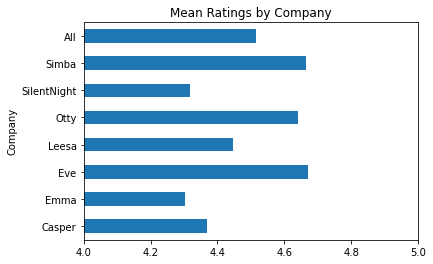

In [240]:
mat_ratings.plot(kind='barh', xlim=(4,5), title='Mean Ratings by Company', legend=False)

So it looks like Simba, Otty and Eve are above the average with the others below. Let's look closer at Emma, who has the worst average rating.

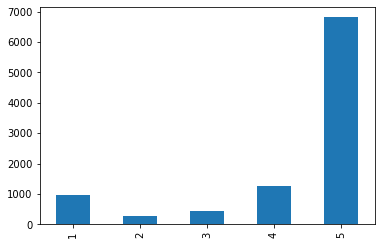

In [271]:
all_reviews['Rating'][all_reviews['Company'] == 'Emma'].value_counts(sort=False).plot.bar()

Tough competition, it looks like they have overwhelmingly 5 star reviews! Since each company has a different number of reviews, we'll convert these ratings to a proportion of total reviews and then plot each company and look at what's happening.

In [313]:
names = ['Emma', 'Eve', 'Casper', 'Simba', 'SilentNight', 'Otty', 'Leesa']
proportions = []
proportions = pd.DataFrame(proportions)
for name in names:
    subset = all_reviews[all_reviews['Company']==name]
    calc = subset['Rating'].value_counts(normalize = True, sort = False)
    proportions[name] = calc

In [314]:
proportions

,Emma,Eve,Casper,Simba,SilentNight,Otty,Leesa
1,0.098049,0.053238,0.071545,0.045284,0.089217,0.038298,0.049628
2,0.028131,0.013970,0.029878,0.014556,0.034860,0.015911,0.026468
3,0.045483,0.014159,0.053252,0.022716,0.049335,0.032747,0.066170
4,0.129261,0.045497,0.147561,0.066823,0.122895,0.092877,0.143921
5,0.699076,0.873136,0.697764,0.850621,0.703693,0.820167,0.713813


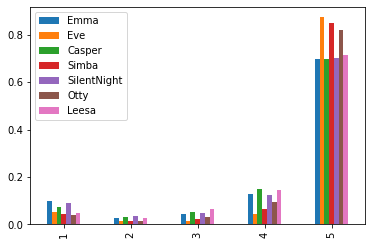

In [315]:
proportions.plot()

It's a little bit hard to compare here, let's create a stacked plot.

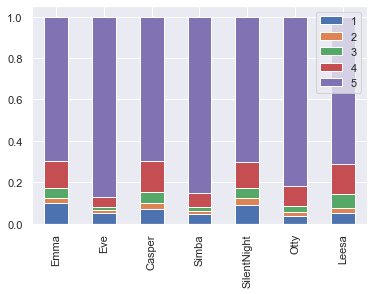

In [540]:
import seaborn as sns
sns.set()
proportions.T.plot(kind='bar', stacked=True)

It looks like Emma has the higherst proportion of 1 star rating, which is obviously dragging their average down. Let's now see how the companies ratings have changed over time. Since each company has different periods, we'll do them separately.

In [357]:
#define function to subset
def subset(company):
    subset = all_reviews[all_reviews['Company'] == company]
    return subset


In [494]:
emma_clean = subset('Emma')
emma_clean



,Header,Review,Rating,Name,Location,Date,Company
0,I ordered the hybrid mattress,I ordered the hybrid mattress....,5,Ramiro Cali-Corleo,Malta,2020-09-05,Emma
1,I much enjoy my Emma mattress together…,I much enjoy my Emma mattress ...,5,Margrit Dahm,United Kingdom,2020-09-05,Emma
2,Amazing mattress and impeccable customer service,This mattress is amazing and t...,5,Emma,United Kingdom,2020-09-05,Emma
3,My son loves his Mattress,My son loves his Mattress can ...,5,Annie,United Kingdom,2020-09-05,Emma
4,Best nights sleep ever,Having bought a double and a s...,5,Lisa Silver,United Kingdom,2020-09-05,Emma
...,...,...,...,...,...,...,...
10378,"Good products, prompt deliveries and good cust...",So pleased we trusted the revi...,5,Helen,United Kingdom,2018-02-20,Emma
10379,Sadly after 6 weeks on this mattress it…,Excellent company to deal with...,4,Berni Mackinnon,United Kingdom,2018-02-20,Emma
10380,I am a convert!,"Incredible comfort, my sore ba...",5,Customer Esstee.,United Kingdom,2018-02-20,Emma
10381,Happy customer,This is a comfortable mattress...,4,jjgirl,United Kingdom,2018-02-20,Emma


In [502]:
#we're going to calculate after each review, so we expect the beginning to have more variation.
count = 0
rolling_total = 0
mean_values = []
emma_clean = emma_clean.sort_values(by='Date')
for value in emma_clean['Rating']:
    rating = value
    rolling_total += rating
    count += 1
    mean = rolling_total/count
    mean_values.append(mean)

emma_rolling_mean = emma_clean.copy()
emma_rolling_mean['Rolling_mean'] = mean_values

In [503]:
emma_clean

,Header,Review,Rating,Name,Location,Date,Company,Rolling_mean
10382,My wife has had both hips replaced and…,"Best bed we have had, we both ...",5,Ian Newsham,United Kingdom,2018-02-20,Emma,5.000000
10380,I am a convert!,"Incredible comfort, my sore ba...",5,Customer Esstee.,United Kingdom,2018-02-20,Emma,4.500000
10379,Sadly after 6 weeks on this mattress it…,Excellent company to deal with...,4,Berni Mackinnon,United Kingdom,2018-02-20,Emma,4.428571
10378,"Good products, prompt deliveries and good cust...",So pleased we trusted the revi...,5,Helen,United Kingdom,2018-02-20,Emma,4.500000
10377,The most comfortable mattress I have…,A brilliant product - a comfy ...,5,Alison,United Kingdom,2018-02-20,Emma,4.555556
...,...,...,...,...,...,...,...,...
3,My son loves his Mattress,My son loves his Mattress can ...,5,Annie,United Kingdom,2020-09-05,Emma,4.302682
2,Amazing mattress and impeccable customer service,This mattress is amazing and t...,5,Emma,United Kingdom,2020-09-05,Emma,4.302610
1,I much enjoy my Emma mattress together…,I much enjoy my Emma mattress ...,5,Margrit Dahm,United Kingdom,2020-09-05,Emma,4.302538
4,Best nights sleep ever,Having bought a double and a s...,5,Lisa Silver,United Kingdom,2020-09-05,Emma,4.302753


This seemed to work, so we'll define a function below:

In [515]:
def rolling_mean(company_sub):
    count = 0
    rolling_total = 0
    reviews = []
    mean_values = []
    company_sub = company_sub.sort_values(by='Date')
    for value in company_sub['Rating']:
        rating = value
        rolling_total += rating
        count += 1
        #calculate the mean and append it
        mean = rolling_total/count
        mean_values.append(mean)
        #keep track of number of reviews 
        reviews.append(count)

    company_sub = company_sub.copy()
    company_sub['Rolling_mean'] = mean_values
    company_sub['Accumulated_reviews'] = reviews
    return company_sub


emma_clean = subset('Emma')
eve_clean = subset('Eve')
casper_clean = subset('Casper')
simba_clean = subset('Simba')
silentnight_clean = subset('SilentNight')
leesa_clean = subset('Leesa')
otty_clean = subset('Otty')

emma_rolling_mean = rolling_mean(emma_clean)
eve_rolling_mean = rolling_mean(eve_clean)
casper_rolling_mean = rolling_mean(casper_clean)
simba_rolling_mean = rolling_mean(simba_clean)
silentnight_rolling_mean = rolling_mean(silentnight_clean)
leesa_rolling_mean = rolling_mean(leesa_clean)
otty_rolling_mean = rolling_mean(otty_clean)

all_rolling_mean = pd.concat([emma_rolling_mean, eve_rolling_mean, casper_rolling_mean, simba_rolling_mean, silentnight_rolling_mean, leesa_rolling_mean, otty_rolling_mean], axis=0, ignore_index=True)


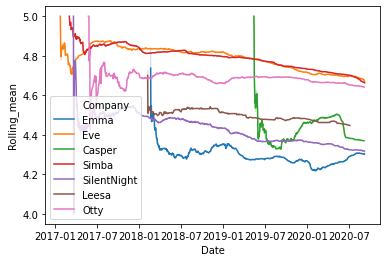

In [507]:
import seaborn as sns
sns.lineplot(data=all_rolling_mean, x='Date', y='Rolling_mean', hue='Company')

Ok, so as expected we're seeing the large variations when the companies started receiving reviews before the rolling average starts to stabilize. Eve and Simba have always had very good reviews, but there is a slight downward trend, this also seems to be the case for Silent Night. Leesa and Otty and relatively stable, while Casper has recently dipped. Emma, although having the lowest overall average, appear to be the only company on an upward trend. Good news for Emma!

I wonder if there is a link between the rate new reviews from customers. I did notice that while perfecting the code for scraping the data, Emma's reviews were continuously increasing. Let's check that out.

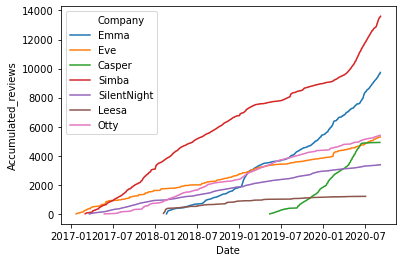

In [517]:
sns.lineplot(data=all_rolling_mean, x='Date', y='Accumulated_reviews', hue='Company')

So probably no link between the rate of reviews since Emma is on par with Simba, although these two companies collect far more reviews than the others. Casper seems to have really leveled off though. I just checked their [website](https://casper.com/uk/en/) and they've stopped selling in Europe to concentrate on the North American market. We'll keep them in the data set to see what people were saying about them, maybe we can see why they closed European operations.

One last thing I wanted to check was whether we can do a break down of customer location.

In [520]:
all_rolling_mean['Location'].describe()

count                                  43559
unique                                    95
top                   United Kingdom        
freq                                   39888
Name: Location, dtype: object

The UK really dominates the reviews, so I don't think this would add much. Maybe in the future we can gather non-English reviews for further insights.

# Natural Language Processing
Earlier we identified Emma as having the lowest average reviews, so let's process the reviews and see if we can identify why customers are so unhappy. 

We have our data set already looking good for the purposes of examining the numbers, but now we want to break down the reviews for each company and that's going to require a bit more cleaning. Briefly, here are the steps we'll take:

- Tokenize the text, which means we split each sentence into separate words;
- Remove punctuation;
- Remove stopwords. These are words that don't really add anything to the meaning of a sentence, things like 'he', 'she', 'because', 'something' etc.;
- Lemmatize our words. This means that we'll convert our words to their root form. For example, 'walk', 'walks' and 'walking' all stem from 'walk'.

Let's begin there and see how this progresses. We'll start with the Emma dataset, which has already been subsetted (emma_clean) from earlier.

## Emma the sleep company

In [542]:
import nltk
from nltk import FreqDist

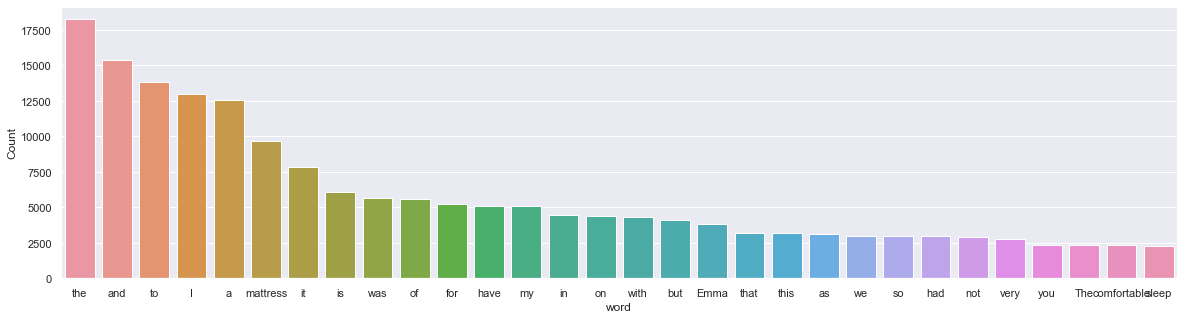

In [543]:
#we quickly look at the frequency of words in the uncleaned dataset
def freq_words(x, terms = 30):
      all_words = ' '.join([text for text in x])
      all_words = all_words.split()

      fdist = FreqDist(all_words)
      words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

      # selecting top 30 most frequent words
      d = words_df.nlargest(columns="count", n = terms) 
      plt.figure(figsize=(20,5))
      ax = sns.barplot(data=d, x= "word", y = "count")
      ax.set(ylabel = 'Count')
      plt.show()
    
freq_words(emma_clean['Review'])

Although there are relevant words like 'mattress' and 'sleep', the majority are not at all informative. We're going to proceed with spacy to clean the data.

In [546]:
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

In [861]:
import spacy

emma_clean = subset('Emma')
#get punctuation list
punctuations = '’!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

#create a list of stop words
stop_words = spacy.lang.en.stop_words.STOP_WORDS

#create a function to remove stopwords and punctuation
def remove_stopword(review):
    review_new = ' '.join([word for word in review if word not in stop_words and word not in punctuations])
    return review_new

            
emma_clean_copy = emma_clean.copy()

#remove stopwords
reviews = [remove_stopword(r.split()) for r in emma_clean_copy['Review']]

#make lowercase and remove remaining punctuation
for punc in punctuations:
    reviews = [r.replace(punc, " ") for r in reviews]
reviews = [r.strip().lower() for r in reviews]

#remove extra spaces
reviews = [re.sub(' +', ' ', r) for r in reviews]
#remove words with 3 letters or less
reviews = [re.sub(r'\b\w{1,3}\b', '', r) for r in reviews]

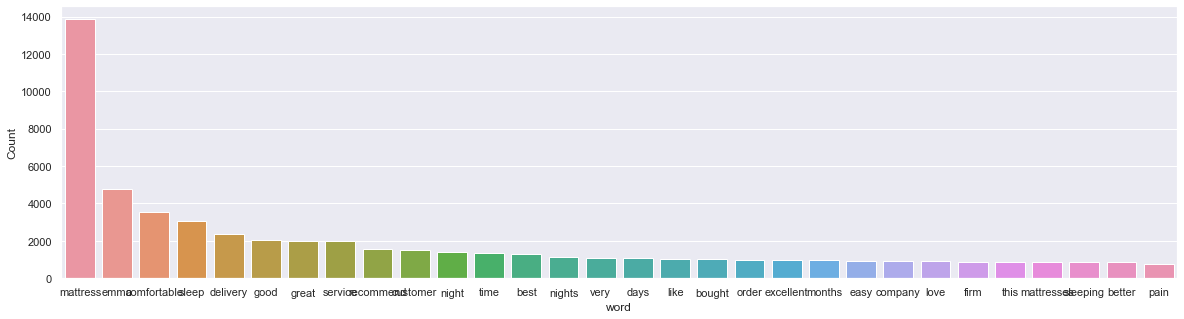

In [862]:
freq_words(reviews)

This is looking better. Mattress is the most common word which makes sense. We've removed a bunch of words that don't mean anything by themselves and now have words like 'delivery', 'service', ,'order' and 'pain', which seem like relevant words. In these top 30 words, we also see 'sleep' and 'sleeping', which we can fix now by lemmatizing. This means the words will be reduced to their basic form, so sleep and sleeping will just become 'sleep'.

We can further reduce the word list to include only nouns and adjectives to remove things like 'very' and 'this'.

In [863]:
import en_core_web_sm
nlp = en_core_web_sm.load()

def lemmatization(texts, tags=['NOUN', 'ADJ', 'VERB']):
    lemma_out = []
    for i in texts:
             doc = nlp(" ".join(i)) 
             lemma_out.append([token.lemma_ for token in doc if token.pos_ in tags])
    return lemma_out

#tokenize each review
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])

['enjoy', 'emma', 'mattress', 'emma', 'pillows', 'they', 'help', 'good', 'night', 'rest']


We get a good idea of what the first review is talking about still. 

In [864]:

reviews_lemma = lemmatization(tokenized_reviews)
print(reviews_lemma[1])

['enjoy', 'pillow', 'help', 'good', 'night', 'rest']


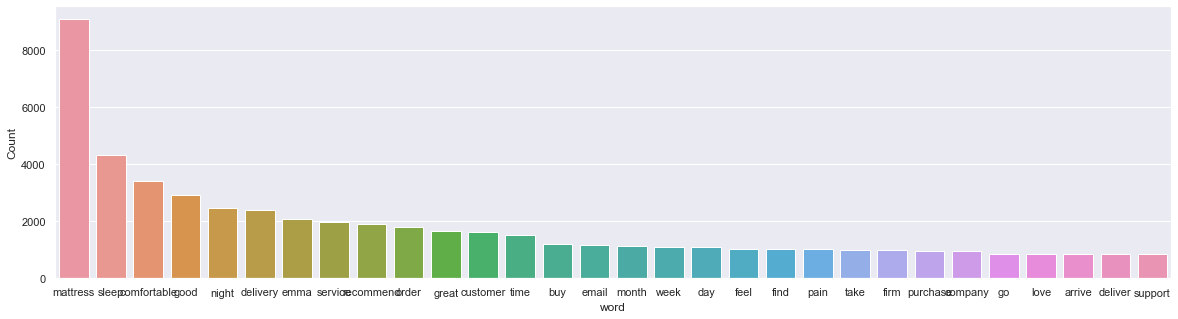

In [865]:
emma_clean_copy_2 = emma_clean.copy()

#add the lemmatized and cleaned reviews back to the original tables
reviews_3 = []
for i in range(len(reviews_lemma)):
    reviews_3.append(' '.join(reviews_lemma[i]))

emma_clean_copy_2['Reviews'] = reviews_3

freq_words(emma_clean_copy_2['Reviews'])

Looks like we have some relevant words here. Let's build a Latent Dirichlet Allocation (LDA) model. This is a matrix factorization technique that tries to predict topics. Essentially, LDA takes a number of documents (in this case reviews) and assumes that they are made up of different topics. It then backtracks and tries to figure out which topics could make those reviews in the first place.

In [638]:
import gensim
from gensim import corpora

In [866]:
# Create a dictionary of words from all reviews
dictionary = corpora.Dictionary(reviews_lemma)

In [867]:
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_lemma]

In [868]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=10, random_state=100,
                chunksize=200, passes=50)

In [869]:
lda_model.print_topics()

[(0,
  '0.104*"mattress" + 0.065*"comfortable" + 0.050*"great" + 0.047*"delivery" + 0.034*"good" + 0.029*"sleep" + 0.024*"recommend" + 0.024*"excellent" + 0.023*"easy" + 0.019*"service"'),
 (1,
  '0.155*"sleep" + 0.124*"night" + 0.067*"good" + 0.061*"mattress" + 0.053*"pain" + 0.040*"comfortable" + 0.027*"wake" + 0.025*"ache" + 0.019*"feel" + 0.017*"get"'),
 (2,
  '0.059*"delivery" + 0.054*"order" + 0.039*"email" + 0.037*"company" + 0.029*"day" + 0.029*"week" + 0.029*"refund" + 0.026*"receive" + 0.026*"return" + 0.025*"tell"'),
 (3,
  '0.107*"mattress" + 0.056*"recommend" + 0.040*"buy" + 0.035*"year" + 0.033*"comfortable" + 0.032*"emma" + 0.026*"good" + 0.022*"would" + 0.021*"sleep" + 0.019*"purchase"'),
 (4,
  '0.083*"customer" + 0.071*"service" + 0.031*"send" + 0.029*"emma" + 0.027*"mattress" + 0.021*"company" + 0.020*"say" + 0.019*"phone" + 0.017*"contact" + 0.015*"work"'),
 (5,
  '0.053*"deliver" + 0.052*"edge" + 0.036*"summer" + 0.035*"efficient" + 0.032*"happen" + 0.029*"daughter

In [870]:
import pyLDAvis
import pyLDAvis.gensim

# Visualize the different topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.195266 -0.042970       1        1  16.688326
6     -0.106494  0.138720       2        1  15.687710
2      0.042212  0.292750       3        1  12.877846
3     -0.210560 -0.053622       4        1  12.335740
1     -0.176614 -0.183034       5        1  11.610151
4     -0.027327  0.226917       6        1  11.590636
7      0.227830 -0.024904       7        1   6.570266
8     -0.035273 -0.138351       8        1   6.168721
9      0.181705 -0.186377       9        1   3.624914
5      0.299786 -0.029128      10        1   2.845685, topic_info=          Term         Freq        Total Category  logprob  loglift
70       sleep  4093.000000  4093.000000  Default  30.0000  30.0000
25       night  2299.000000  2299.000000  Default  29.0000  29.0000
2     customer  1542.000000  1542.000000  Default  28.0000  28.0000
95    delivery  2463.000000  2463.000000  Default  27.0000  27.0000
48     service  1845.000000  1845.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
1429     raise    32.882271    33.793854  Topic10  -4.9317   3.5320
642       item    74.342888   114.428398  Topic10  -4.1160   3.1281
290       warm   129.979584   315.862183  Topic10  -3.5573   2.6714
3      deliver   239.659409   936.828979  Topic10  -2.9454   2.1961
226       will    39.586807   122.251732  Topic10  -4.7461   2.4318

[515 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
291       6  0.988531  account
89        5  0.998341     ache
381       9  0.976405      add
620       6  0.990457  address
1357      9  0.988223   adjust
...     ...       ...      ...
1241      4  0.972564     wrap
111       4  0.129535    wrong
111       6  0.865841    wrong
86        2  0.199270     year
86        4  0.799385     year

[627 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 7, 3, 4, 2, 5, 8, 9, 10, 6])

Above we are visualizing our 10 topics. On the left the topics are represented by circles whose centres are placed by calculating the Jensen-Shannon divergence between topics and then using multidimensional scaling for inter-topic differences. In other words, the further apart the circles are, the more different the topics are likely to be. The size of the circle represents the prevalance of the topic. 

On the right hand side we have an overlap of the words and their frequency in the entire dataset (blue) and their prevalance in the selected topic. The λ slider allows to rank the terms according to term relevance. The optimal value in the LDAvis [documentation](http://bl.ocks.org/AlessandraSozzi/raw/ce1ace56e4aed6f2d614ae2243aab5a5/) is suggested to be 0.6.

The topics predicted seem relevant. For example, topic 9 appears to be about returns and refunds, topic 4 is perhaps more unhappy customers reporting aches and pains, while in topic 7 the top 3 terms are 'would', 'recommend', 'friend', so probably some happy customers there. This topic modelling might be more informative if we look at topics of unhappy customers, or those who rated the company as 1 or 2 stars. In this way we can look at the pain points from the customer perspective. 

But first we should look at topic coherence, that is the average similarity between the top words in a given topic. We might be able to improve the topic coherence and the model.

In [871]:
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=reviews_lemma, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5006080048113015


Let's see if we can improve the coherence score by altering the number of topics. We can then plot this.

In [872]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step =1):
    #our returned values
    coherence_values = []
    model_list = []
    for num_topics in range(start,limit,step):
        model = gensim.models.ldamodel.LdaModel(corpus=doc_term_matrix, id2word=dictionary, num_topics=num_topics, random_state=100,
                chunksize=200, passes=50)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    return model_list, coherence_values

In [873]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus =doc_term_matrix, texts=reviews_lemma, limit=10, start=2, step=1)

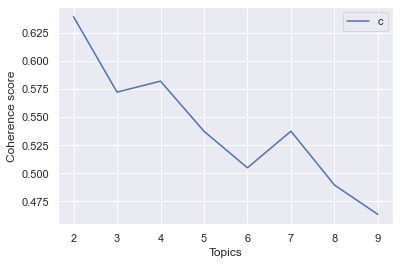

In [875]:
#we can plot this
limit=10 
start=2
step=1
x=range(start,limit,step)
plt.plot(x,coherence_values)
plt.xlabel('Topics')
plt.ylabel('Coherence score')
plt.legend(('coherence_values'), loc='best')
plt.show()

In [876]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model_list[0], doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.182571  0.0       1        1  60.127415
1     -0.182571  0.0       2        1  39.872585, topic_info=            Term         Freq        Total Category  logprob  loglift
70         sleep  3960.000000  3960.000000  Default  30.0000  30.0000
92   comfortable  3400.000000  3400.000000  Default  29.0000  29.0000
48       service  1813.000000  1813.000000  Default  28.0000  28.0000
14         order  1600.000000  1600.000000  Default  27.0000  27.0000
2       customer  1483.000000  1483.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
91        arrive   512.257385   907.478271   Topic2  -4.8257   0.3476
121          try   377.343689   601.375305   Topic2  -5.1314   0.4534
405       review   374.657471   640.730591   Topic2  -5.1385   0.3829
172         take   414.410614   988.177734   Topic2  -5.0377   0.0505
61            go   357.795532   842.446045   Topic2  -5.1846   0.0631

[128 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
89        1  0.998333     ache
89        2  0.002243     ache
29        1  0.997467  amazing
29        2  0.004394  amazing
91        1  0.435272   arrive
...     ...       ...      ...
21        2  0.800121     week
228       1  0.100291     work
228       2  0.900171     work
86        1  0.997056     year
86        2  0.002450     year

[181 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

It looks like 2 is the optimal number of topics for the full dataset. At a glance, it looks like they're separated into good and bad reviews, which is probably appropriate. Let's look again at just the bad reviews.

In [877]:
emma_bad_reviews = emma_clean[emma_clean['Rating'].isin([1,2])]

In [878]:
emma_bad_reviews

,Header,Review,Rating,Name,Location,Date,Company
5,The first mattress we got was in April…,The first mattress we got was ...,2,Mrs A Mustard,United Kingdom,2020-09-04,Emma
14,I am a convert!,Sadly after 6 weeks on this ma...,1,joanne,United Kingdom,2020-09-04,Emma
25,Ordered the Emma king-size mattress…,The first mattress we got was ...,2,Mrs A Mustard,United Kingdom,2020-09-04,Emma
34,My wife has had both hips replaced and…,Sadly after 6 weeks on this ma...,1,joanne,United Kingdom,2020-09-04,Emma
49,Appalling customer service,Very disappointed with the cus...,1,kevin Miller,United Kingdom,2020-09-04,Emma
...,...,...,...,...,...,...,...
10214,Much softer after short time after purchase,I've only had this since Novem...,2,lyndsey,United Kingdom,2018-02-26,Emma
10229,Just OK,The delivery was the only good...,1,Mr David Sims,United Kingdom,2018-02-25,Emma
10264,Very Happy,I have had this now less than ...,1,Jan Cadogan,United Kingdom,2018-02-23,Emma
10302,Very comfortable initially but will not last.,I bought the emma mattress due...,2,Hayley,Ireland,2018-02-23,Emma


In [879]:
#remove stopwords
reviews = [remove_stopword(r.split()) for r in emma_bad_reviews['Review']]

#make lowercase and remove remaining punctuation
for punc in punctuations:
    reviews = [r.replace(punc, " ") for r in reviews]
reviews = [r.strip().lower() for r in reviews]

#remove words with 3 letters or less
reviews = [re.sub(r'\b\w{1,3}\b', '', r) for r in reviews]
#remove extra spaces
reviews = [re.sub(' +', ' ', r) for r in reviews]

#tokenize each review
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])

['sadly', 'weeks', 'mattress', 'wasn', 'soft', 'firm', 'topper', 'sent', 'free', 'made', 'difference', 'sadly', 'waking', 'loads', 'night', 'absolutely', 'boiling', 'sweating', 'however', 'fault', 'emma', 'customer', 'service', 'anyway', 'very', 'prompt', 'very', 'understanding', 'delivery', 'collection', 'fantastic']


In [880]:
reviews_lemma = lemmatization(tokenized_reviews)
print(reviews_lemma[1])

['week', 'soft', 'firm', 'topper', 'send', 'make', 'difference', 'wake', 'load', 'night', 'boil', 'sweat', 'fault', 'emma', 'customer', 'service', 'prompt', 'understanding', 'delivery', 'collection', 'fantastic']


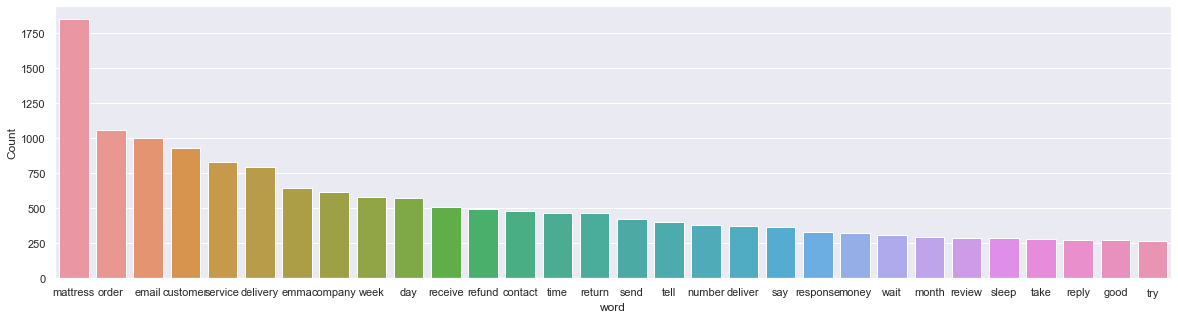

In [881]:
#add the lemmatized and cleaned reviews back to the original tables
reviews_3 = []
for i in range(len(reviews_lemma)):
    reviews_3.append(' '.join(reviews_lemma[i]))

emma_bad_reviews = emma_bad_reviews.copy()
emma_bad_reviews['Reviews'] = reviews_3

freq_words(emma_bad_reviews['Reviews'])

Since these are the bad reviews, I think we can safely say that there are some issues with customer service and deliveries based on this plot. Let's look at the topics.

In [887]:
# Create a dictionary of words from all bad reviews
dictionary = corpora.Dictionary(reviews_lemma)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_lemma]

# Build LDA model with coherence values
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus =doc_term_matrix, texts=reviews_lemma, limit=15, start=2, step=1)

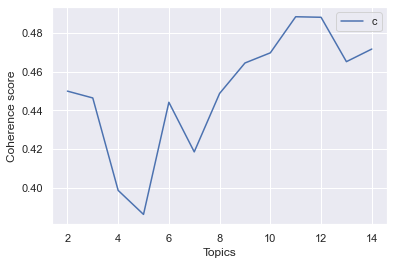

In [888]:
#we can plot this
limit=15
start=2
step=1
x=range(start,limit,step)
plt.plot(x,coherence_values)
plt.xlabel('Topics')
plt.ylabel('Coherence score')
plt.legend(('coherence_values'), loc='best')
plt.show()

It seems like 11 or 12 is giving us the best scores here, let's quickly check.

In [890]:
print("\nNumber of Topics: 11", "Coherence Value: ", coherence_values[9])
print("\nNumber of Topics: 12", "Coherence Value: ", coherence_values[10])


Number of Topics: 11 Coherence Value:  0.4883790515167501

Number of Topics: 12 Coherence Value:  0.48810269694729547


11 topics is the best by a marginal fraction, so we'll proceed with that.

In [891]:
# Visualize the different topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model_list[9], doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.358182 -0.042860       1        1  60.702984
2     -0.304596 -0.137636       2        1  24.394932
5     -0.155438  0.314849       3        1   5.797684
4      0.065501 -0.148096       4        1   2.497193
6      0.124853 -0.007208       5        1   1.456754
3      0.103528 -0.018962       6        1   1.386646
10     0.104330  0.039783       7        1   1.133383
8      0.107535  0.010127       8        1   0.894883
7      0.111138 -0.000265       9        1   0.792067
0      0.105301 -0.005103      10        1   0.568736
1      0.096032 -0.004630      11        1   0.374730, topic_info=                Term         Freq        Total Category  logprob  loglift
43           company   687.000000   687.000000  Default  30.0000  30.0000
7           mattress  1926.000000  1926.000000  Default  29.0000  29.0000
364            offer   160.000000   160.000000  Default  28.0000  28.0000
21          customer   855.000000   855.000000  Default  27.0000  27.0000
52             order  1047.000000  1047.000000  Default  26.0000  26.0000
...              ...          ...          ...      ...      ...      ...
1031  circumstantial     0.301081     0.943462  Topic11  -6.3761   4.4445
1029          abrupt     0.301081     0.943462  Topic11  -6.3761   4.4445
1049         torture     0.301081     0.943462  Topic11  -6.3761   4.4445
1045     reminiscent     0.301081     0.943462  Topic11  -6.3761   4.4445
1048      smallprint     0.301081     0.943462  Topic11  -6.3761   4.4445

[468 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1555      5  0.860773         24th
257       1  0.693541      account
257       8  0.308240      account
1443      4  0.928750  acknowledge
853       1  0.426163       actual
...     ...       ...          ...
18        2  0.969248         year
18        7  0.029671         year
2337      7  0.929884       yellow
256       4  0.986703    yesterday
1291      7  0.762569            😡

[519 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 3, 6, 5, 7, 4, 11, 9, 8, 1, 2])

Wow, this is where customers are clearly upset. It looks like the biggest pain point has to do with customer service and deliveries, as defined by topic 1 and 2. Topic 5 suggest there might be a strong smell as well, not ideal. To give a little more context, let's take a look at the bigrams, where we take 2 consecutive words.

In [899]:
from nltk import bigrams
bigram_terms = [list(bigrams(review)) for review in tokenized_reviews]

In [893]:
import itertools
import collections
# Flatten list of bigrams in clean review
bigrams = list(itertools.chain(*bigram_terms))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)

bigram_counts.most_common(20)


[(('customer', 'service'), 575),
 (('emma', 'mattress'), 320),
 (('ordered', 'mattress'), 128),
 (('working', 'days'), 96),
 (('customer', 'services'), 91),
 (('phone', 'number'), 91),
 (('delivery', 'date'), 88),
 (('order', 'number'), 83),
 (('mattress', 'delivered'), 74),
 (('received', 'email'), 65),
 (('customer', 'support'), 64),
 (('return', 'mattress'), 62),
 (('contacted', 'emma'), 60),
 (('mattress', 'arrived'), 58),
 (('mattress', 'collected'), 58),
 (('telephone', 'number'), 54),
 (('cancelled', 'order'), 53),
 (('placed', 'order'), 51),
 (('days', 'later'), 49),
 (('cancel', 'order'), 46)]

In [894]:
bigram_df = pd.DataFrame(bigram_counts.most_common(30), columns=['bigram', 'count'])

In [895]:
def freq_bigrams(x, terms = 30):
    d = x.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "bigram", y = "count")
    ax.set(ylabel = 'Count')
    for item in ax.get_xticklabels():
        item.set_rotation(90)
    plt.show()

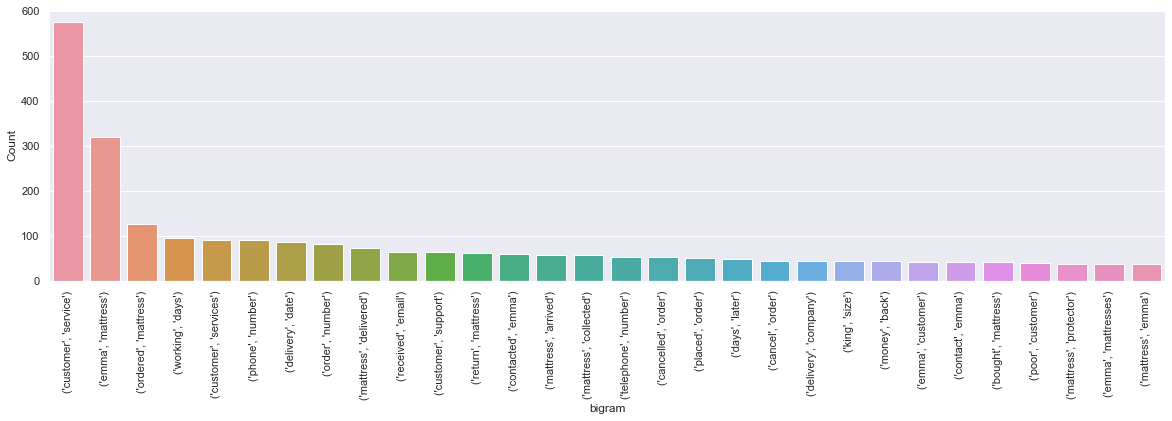

In [896]:
freq_bigrams(bigram_df)

This really just confirms what we saw in our topic models with 'customer service' taking out top spot for negative reviews.

Now we'll continue on with other companies to compare. As a reminder, these are the other companies:

- Casper
- SilentNight
- Leesa
- Otty
- Simba
- Eve

## Casper
To begin with, we'll define some functions to simplify what we've done above.

In [906]:
def clean_reviews(company_subset):
    #remove stopwords
    reviews = [remove_stopword(r.split()) for r in company_subset['Review']]

    #make lowercase and remove remaining punctuation
    for punc in punctuations:
        reviews = [r.replace(punc, " ") for r in reviews]
    reviews = [r.strip().lower() for r in reviews]

    
    #remove words with 3 letters or less
    reviews = [re.sub(r'\b\w{1,3}\b', '', r) for r in reviews]
    #remove extra spaces
    reviews = [re.sub(' +', ' ', r) for r in reviews]
    return reviews

def token_lemma(reviews):
    #tokenize each review
    tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
    reviews_lemma = lemmatization(tokenized_reviews)
    return tokenized_reviews, reviews_lemma 

def get_LDA_vis(reviews_lemma, num_topics):
    #Create a dictionary of words from all bad reviews
    dictionary = corpora.Dictionary(reviews_lemma)
    doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_lemma]

    # Creating the object for LDA model using gensim library
    LDA = gensim.models.ldamodel.LdaModel

    # Build LDA model
    lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=num_topics, random_state=100,
                chunksize=200, passes=50)
    # Visualize the different topics
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
    return vis

def get_bigrams(tokenized_reviews):
    bigram_terms = [bigrams(review) for review in tokenized_reviews]
    bigram_terms = list(bigram_terms)
    # Flatten list of bigrams in clean review
    tok_bigrams = list(itertools.chain(*bigram_terms))

    # Create counter of words in clean bigrams
    bigram_counts = collections.Counter(tok_bigrams)
    bigram_df = pd.DataFrame(bigram_counts.most_common(30), columns=['bigram', 'count'])
    return bigram_df

In [897]:
casper_sub = subset('Casper')
casper_clean = clean_reviews(casper_sub)
casper_token, casper_lemma = token_lemma(casper_clean)
casper_LDA = get_LDA_vis(casper_lemma)
casper_LDA

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.275750 -0.049364       1        1  32.383327
9      0.194134  0.181148       2        1  20.286507
2      0.211885 -0.227667       3        1  12.237322
8      0.159445 -0.020343       4        1   9.021720
1      0.035922  0.234293       5        1   7.529668
0     -0.194825 -0.051859       6        1   4.542202
6     -0.149437 -0.021145       7        1   3.601966
4     -0.182788 -0.016222       8        1   3.540648
3     -0.166820 -0.000161       9        1   3.494944
7     -0.183266 -0.028681      10        1   3.361697, topic_info=            Term        Freq       Total Category  logprob  loglift
147      service  511.000000  511.000000  Default  30.0000  30.0000
39      delivery  595.000000  595.000000  Default  29.0000  29.0000
182       pillow  367.000000  367.000000  Default  28.0000  28.0000
6          great  409.000000  409.000000  Default  27.0000  27.0000
14         sleep  690.000000  690.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
455         pour   24.656326   95.251572  Topic10  -3.9952   2.0412
448   impossible    7.571239   15.599066  Topic10  -5.1758   2.6699
1485      ersten    9.746264   53.825943  Topic10  -4.9233   1.6839
773         très    7.120882   45.534721  Topic10  -5.2372   1.5373
1305    couchage    5.976770   14.845172  Topic10  -5.4123   2.4829

[515 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1066      6  0.907485        aber
1423      9  0.980842        ache
1102      8  0.943263  adaptation
1124      5  0.920148     address
1121      4  0.187992      advise
...     ...       ...         ...
1333      7  0.828830           £
1922      8  0.922522      épaule
1243      6  0.318700       était
1243      8  0.637400       était
525       6  0.930658           👍

[644 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 10, 3, 9, 2, 1, 7, 5, 4, 8])

There is some overwhelmingly positive reviews here, let's look at the bigrams.

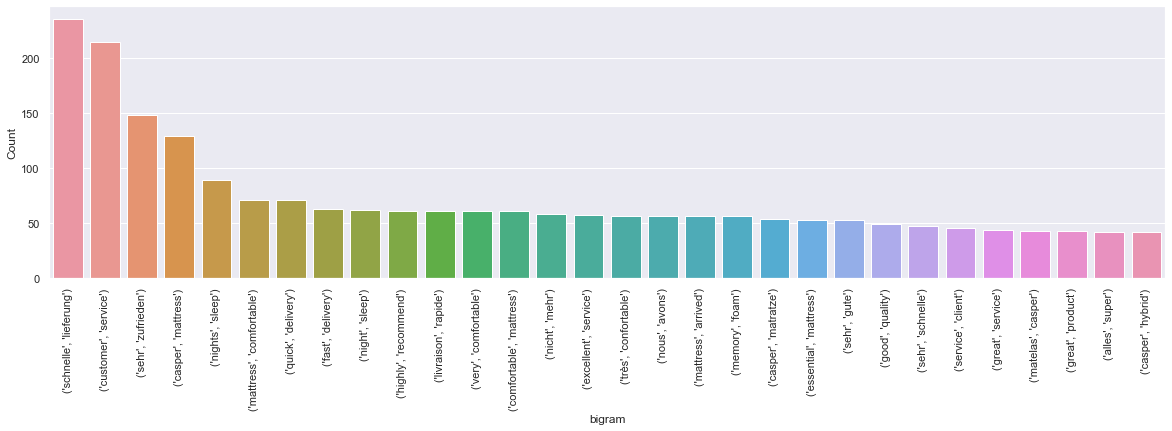

In [900]:
casper_bigrams = get_bigrams(casper_token)
freq_bigrams(casper_bigrams)

Seems like we have a few German reviews mixed in, which is ok. Fast delivery (schnelle lieferung) and very satisfied (sehr zufrieden) are among the top terms, in contrast to Emma who had reviews more about the comfort. Let's switch to the negative reviews quickly.

In [901]:
casper_bad_reviews = casper_sub[casper_sub['Rating'].isin([1,2])]

In [902]:
casper_bad_clean = clean_reviews(casper_bad_reviews)
casper_bad_token, casper_bad_lemma = token_lemma(casper_bad_clean)

#define values for LDA model
dictionary = corpora.Dictionary(casper_bad_lemma)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in casper_bad_lemma]

# Build LDA model with coherence values
casper_bad_model_list, casper_bad_coherence_values = compute_coherence_values(dictionary=dictionary, corpus =doc_term_matrix, texts=casper_bad_lemma, limit=15, start=2, step=1)

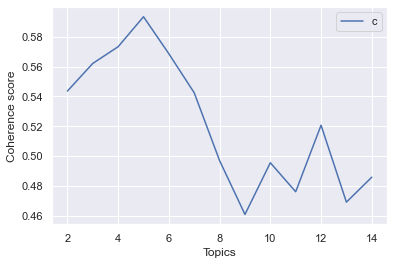

In [904]:
limit=15
start=2
step=1
x=range(start,limit,step)
plt.plot(x,casper_bad_coherence_values)
plt.xlabel('Topics')
plt.ylabel('Coherence score')
plt.legend(('coherence_values'), loc='best')
plt.show()

In [907]:
# 5 topics is the winner for Casper
casper_bad_LDA = get_LDA_vis(casper_bad_lemma, 5)
casper_bad_LDA

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.199498  0.167118       1        1  52.323605
2      0.087532 -0.155238       2        1  20.416460
0      0.041731 -0.097174       3        1  15.064528
3     -0.207442  0.062100       4        1   8.115638
1     -0.121319  0.023194       5        1   4.079772, topic_info=         Term        Freq       Total Category  logprob  loglift
9    mattress  219.000000  219.000000  Default  30.0000  30.0000
48      order  145.000000  145.000000  Default  29.0000  29.0000
279    pillow   42.000000   42.000000  Default  28.0000  28.0000
14      sleep   65.000000   65.000000  Default  27.0000  27.0000
178     night   46.000000   46.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
44       mail    4.512190   12.471876   Topic5  -4.2688   2.1824
469     claim    1.864652    3.713488   Topic5  -5.1525   2.5102
950     point    2.006136   13.682471   Topic5  -5.0794   1.2792
783    matela    1.231040    3.622702   Topic5  -5.5678   2.1198
135      send    1.309840   47.368393   Topic5  -5.5057  -0.3889

[253 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
24        1  0.975226     able
513       1  0.990091  account
859       4  0.965389     alor
25        1  0.888836   arrive
25        2  0.068372   arrive
...     ...       ...      ...
170       1  0.245486     year
170       2  0.136381     year
170       3  0.627353     year
840       3  0.926629        £
804       4  0.952792    était

[294 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 1, 4, 2])

Customer service is also a big pain point here.

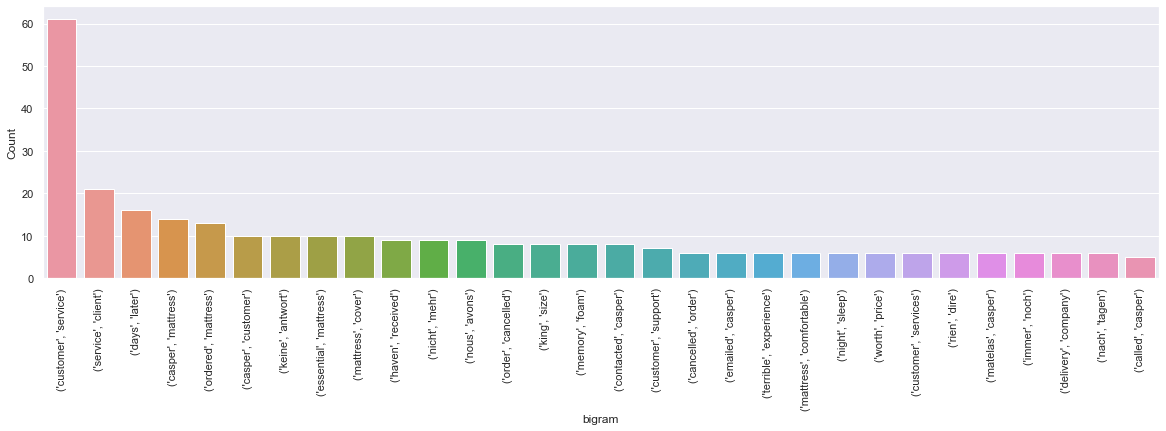

In [845]:
casper_bad_bigrams = get_bigrams(casper_bad_token)
freq_bigrams(casper_bad_bigrams)

Again some patterns emerge with poor customer service and no answer (keine antwort), cancellations of orders and orders not arriving.

## SilentNight

In [846]:
silentnight_sub = subset('SilentNight')
silentnight_clean = clean_reviews(silentnight_sub)
silentnight_token, silentnight_lemma = token_lemma(silentnight_clean)
silentnight_LDA = get_LDA_vis(silentnight_lemma)
silentnight_LDA

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.226449 -0.066126       1        1  20.889780
8      0.017510  0.252347       2        1  16.213440
5      0.236011  0.134072       3        1  16.164822
3      0.078793 -0.035051       4        1  11.943960
0      0.183567 -0.158203       5        1  10.284961
2     -0.041332 -0.005423       6        1   9.720171
7     -0.089479 -0.169200       7        1   5.348907
9     -0.184745  0.192020       8        1   4.784693
4     -0.223960 -0.072489       9        1   3.013918
6     -0.202815 -0.071946      10        1   1.635351, topic_info=         Term         Freq        Total Category  logprob  loglift
12   delivery  2104.000000  2104.000000  Default  30.0000  30.0000
40       time   769.000000   769.000000  Default  29.0000  29.0000
192   service  1006.000000  1006.000000  Default  28.0000  28.0000
117     night   563.000000   563.000000  Default  27.0000  27.0000
25   mattress  1760.000000  1760.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
211      easy     5.985587   303.309937  Topic10  -4.8444   0.1879
204    please     3.813262    39.386105  Topic10  -5.2953   1.7784
100      make     4.182766    89.093491  Topic10  -5.2028   1.0546
263      site     3.843683    67.888786  Topic10  -5.2873   1.2419
500   request     3.592520    34.147293  Topic10  -5.3549   1.8615

[636 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
337       4  0.070699      accept
337       7  0.883733      accept
1488      7  0.898511  acceptable
599       8  0.856478      access
670       3  0.953919    accurate
...     ...       ...         ...
49        6  0.296643       wrong
182       2  0.710558        year
182       6  0.150542        year
182       8  0.132477        year
418       3  0.929264           👍

[983 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 9, 6, 4, 1, 3, 8, 10, 5, 7])

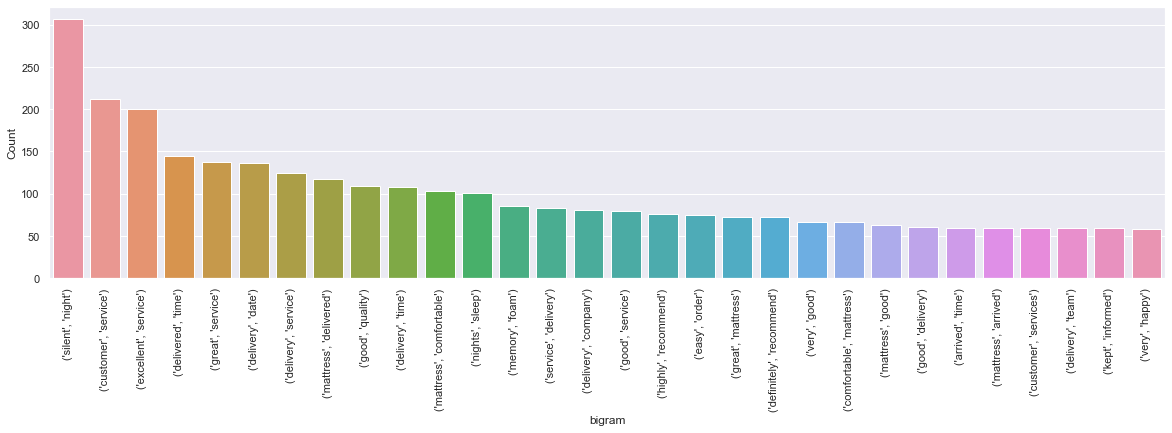

In [847]:
silentnight_bigrams = get_bigrams(silentnight_token)
freq_bigrams(silentnight_bigrams)

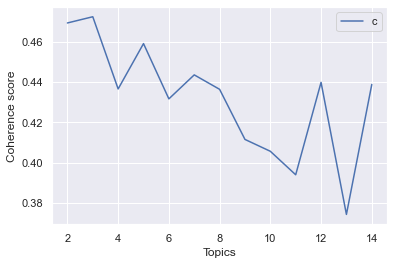

In [908]:
silentnight_bad_reviews = silentnight_sub[silentnight_sub['Rating'].isin([1,2])]
silentnight_bad_clean = clean_reviews(silentnight_bad_reviews)
silentnight_bad_token, silentnight_bad_lemma = token_lemma(silentnight_bad_clean)

#define values for LDA model
dictionary = corpora.Dictionary(silentnight_bad_lemma)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in silentnight_bad_lemma]

# Build LDA model with coherence values
silentnight_bad_model_list, silentnight_bad_coherence_values = compute_coherence_values(dictionary=dictionary, corpus =doc_term_matrix, texts=silentnight_bad_lemma, limit=15, start=2, step=1)

# Plot results
limit=15
start=2
step=1
x=range(start,limit,step)
plt.plot(x,silentnight_bad_coherence_values)
plt.xlabel('Topics')
plt.ylabel('Coherence score')
plt.legend(('coherence_values'), loc='best')
plt.show()



In [910]:
silentnight_bad_LDA = get_LDA_vis(silentnight_bad_lemma, 3)
silentnight_bad_LDA

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.198209 -0.004532       1        1  48.710335
2      0.103300 -0.158313       2        1  34.894447
1      0.094909  0.162844       3        1  16.395224, topic_info=         Term        Freq       Total Category  logprob  loglift
130   service  127.000000  127.000000  Default  30.0000  30.0000
134  customer  103.000000  103.000000  Default  29.0000  29.0000
12   delivery  392.000000  392.000000  Default  28.0000  28.0000
186     night  142.000000  142.000000  Default  27.0000  27.0000
32   purchase   89.000000   89.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
25   mattress   13.821097  265.277374   Topic3  -4.8642  -1.1464
56       take   11.528638   73.738525   Topic3  -5.0456  -0.0475
118      year   10.172810   48.533676   Topic3  -5.1707   0.2456
20         go   10.416935   64.120789   Topic3  -5.1470  -0.0092
151   deliver    9.995628  176.672272   Topic3  -5.1883  -1.0640

[197 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
845       1  0.990073       accept
1253      2  0.907082       actual
1089      3  0.921396      apology
323       3  0.976137    appalling
202       3  0.916870       appear
...     ...       ...          ...
48        2  0.096324         work
762       2  0.990809  workmanship
49        1  0.988804        wrong
118       2  0.782961         year
118       3  0.206042         year

[221 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

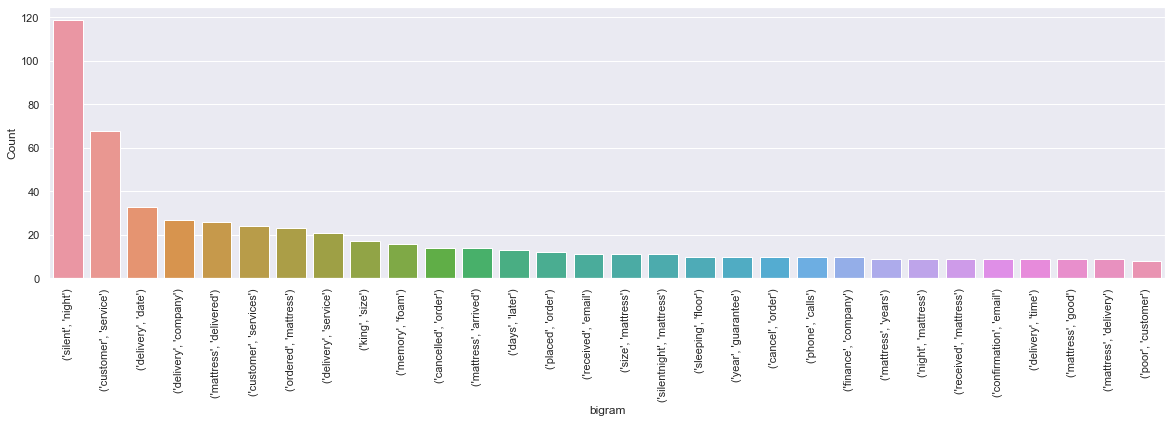

In [849]:
silentnight_bad_bigrams = get_bigrams(silentnight_bad_token)
freq_bigrams(silentnight_bad_bigrams)

## Simba
Let's switch to the highest rated company and also the company with the most reviews.

In [854]:
simba_sub = subset('Simba')
simba_clean = clean_reviews(simba_sub)
simba_token, simba_lemma = token_lemma(simba_clean)
simba_LDA = get_LDA_vis(simba_lemma)
simba_LDA

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.186073 -0.012098       1        1  27.752363
1      0.102799 -0.108743       2        1  21.654793
3     -0.011780 -0.206498       3        1   9.353824
8     -0.162135  0.003440       4        1   9.020742
2      0.238570 -0.223058       5        1   6.955218
4     -0.023148 -0.059216       6        1   6.257617
9     -0.287638  0.018675       7        1   5.272962
5      0.110876  0.256208       8        1   5.193136
0      0.112076  0.105677       9        1   4.694740
7      0.106452  0.225615      10        1   3.844599, topic_info=            Term          Freq         Total Category  logprob  loglift
41         sleep   7974.000000   7974.000000  Default  30.0000  30.0000
74      delivery   3640.000000   3640.000000  Default  29.0000  29.0000
96       service   3079.000000   3079.000000  Default  28.0000  28.0000
23      mattress  11114.000000  11114.000000  Default  27.0000  27.0000
32        pillow   1973.000000   1973.000000  Default  26.0000  26.0000
..           ...           ...           ...      ...      ...      ...
185         live     71.310249    191.203461  Topic10  -4.7836   2.2722
319      compare     61.555584    127.991592  Topic10  -4.9307   2.5265
582  temperature     62.400383    135.269485  Topic10  -4.9171   2.4848
261          buy     92.042984   1572.413330  Topic10  -4.5284   0.4204
318        cheap     51.943504    173.870270  Topic10  -5.1005   2.0503

[575 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1574      3  0.985778  absolute
2143      8  0.963810  accident
191       1  0.999472      ache
1323      4  0.954816      achy
434       5  0.982812    actual
...     ...       ...       ...
696       2  0.986868     write
153       1  0.786276      year
153       2  0.213361      year
567      10  0.977208         £
113       7  0.987881         👍

[807 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 2, 4, 9, 3, 5, 10, 6, 1, 8])

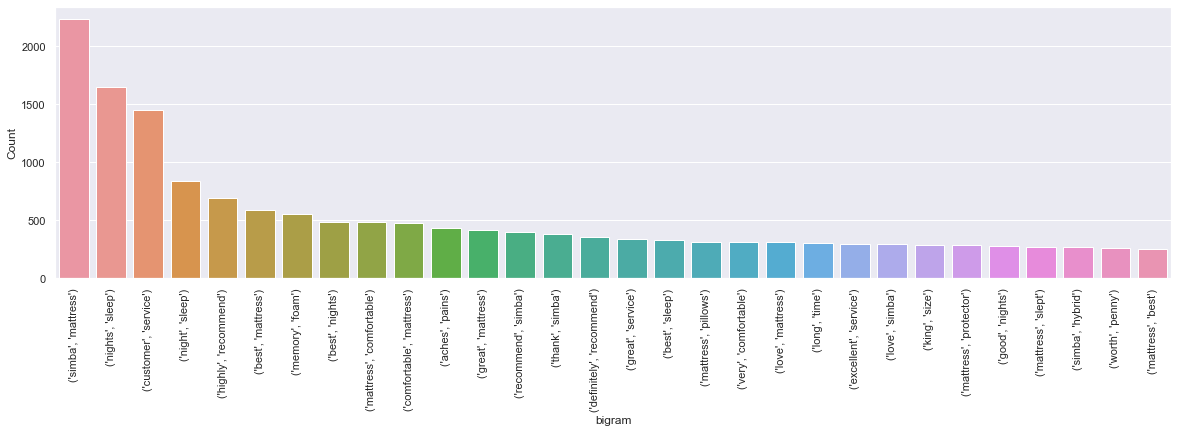

In [855]:
simba_bigrams = get_bigrams(simba_token)
freq_bigrams(simba_bigrams)

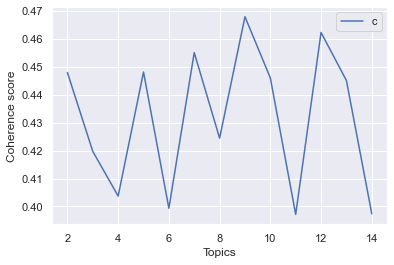

In [909]:
simba_bad_reviews = simba_sub[simba_sub['Rating'].isin([1,2])]
simba_bad_clean = clean_reviews(simba_bad_reviews)
simba_bad_token, simba_bad_lemma = token_lemma(simba_bad_clean)

#define values for LDA model
dictionary = corpora.Dictionary(simba_bad_lemma)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in simba_bad_lemma]

# Build LDA model with coherence values
simba_bad_model_list, simba_bad_coherence_values = compute_coherence_values(dictionary=dictionary, corpus =doc_term_matrix, texts=simba_bad_lemma, limit=15, start=2, step=1)

# Plot results
limit=15
start=2
step=1
x=range(start,limit,step)
plt.plot(x,simba_bad_coherence_values)
plt.xlabel('Topics')
plt.ylabel('Coherence score')
plt.legend(('coherence_values'), loc='best')
plt.show()


In [912]:
simba_bad_LDA = get_LDA_vis(simba_bad_lemma, 9)
simba_bad_LDA

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.225362  0.017575       1        1  49.943108
1      0.308069 -0.004283       2        1  25.462460
0     -0.065837  0.182928       3        1   7.394963
7      0.048268 -0.280052       4        1   6.256132
4      0.045742  0.180344       5        1   5.660547
8     -0.157025 -0.072853       6        1   2.714694
5     -0.139340 -0.012017       7        1   1.261774
3     -0.136902 -0.007267       8        1   0.689841
6     -0.128338 -0.004375       9        1   0.616481, topic_info=           Term         Freq        Total Category  logprob  loglift
27     delivery   466.000000   466.000000  Default  30.0000  30.0000
15        sleep   362.000000   362.000000  Default  29.0000  29.0000
6      mattress  1236.000000  1236.000000  Default  28.0000  28.0000
423      return   258.000000   258.000000  Default  27.0000  27.0000
113      pillow   167.000000   167.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
478        suit     1.069957     8.726255   Topic9  -5.2157   2.9902
1540   chemical     1.026883     8.244566   Topic9  -5.2568   3.0059
304   procedure     0.609643     2.941553   Topic9  -5.7782   3.5151
1430     muscle     0.624362     4.206118   Topic9  -5.7543   3.1813
513       stiff     0.581650     8.785850   Topic9  -5.8252   2.3739

[472 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
825       2  0.986483    00pm
538       8  0.808750    19th
1313      8  0.732415   24hrs
1000      4  0.892251    27th
646       4  0.249058  accept
...     ...       ...     ...
145       2  0.718605    work
145       3  0.076447    work
3183      5  0.983227    wrap
100       1  0.811578    year
100       4  0.184917    year

[571 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 8, 5, 9, 6, 4, 7])

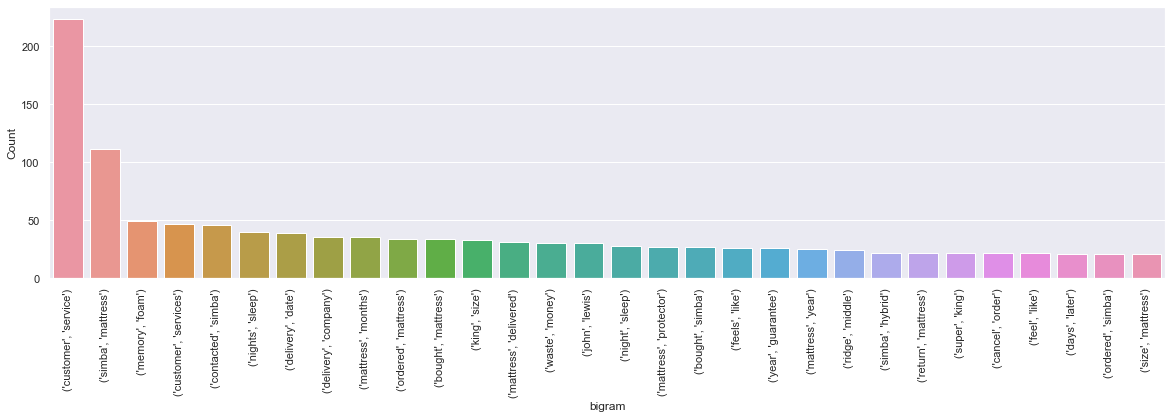

In [853]:
simba_bad_bigrams = get_bigrams(simba_bad_token)
freq_bigrams(simba_bad_bigrams)

## Leesa

In [913]:
leesa_sub = subset('Leesa')
leesa_clean = clean_reviews(leesa_sub)
leesa_token, leesa_lemma = token_lemma(leesa_clean)
leesa_LDA = get_LDA_vis(leesa_lemma, 10)
leesa_LDA

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.267694 -0.030559       1        1  25.517958
3      0.129429 -0.049519       2        1  18.289873
6      0.175715  0.104208       3        1  14.079497
4     -0.026687 -0.207004       4        1   9.907902
0      0.189295  0.084911       5        1   9.211473
9     -0.111263 -0.212559       6        1   7.261275
2     -0.130390  0.104760       7        1   6.850208
5     -0.119324  0.048130       8        1   3.772528
7     -0.188703  0.096548       9        1   3.306133
8     -0.185767  0.061083      10        1   1.803152, topic_info=               Term        Freq       Total Category  logprob  loglift
23            sleep  555.000000  555.000000  Default  30.0000  30.0000
40         delivery  189.000000  189.000000  Default  29.0000  29.0000
62            night  298.000000  298.000000  Default  28.0000  28.0000
80           change  113.000000  113.000000  Default  27.0000  27.0000
66            great  290.000000  290.000000  Default  26.0000  26.0000
..              ...         ...         ...      ...      ...      ...
193           saggy    0.996123    1.811801  Topic10  -5.7374   3.4174
161  recommendation    2.298270    6.657973  Topic10  -4.9013   2.9520
167           state    1.952805    8.545705  Topic10  -5.0642   2.5395
466     traditional    1.503978    5.093566  Topic10  -5.3254   2.7958
333       different    1.144255   19.351290  Topic10  -5.5987   1.1876

[512 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
77        4  0.955363    able
0         1  0.966608    ache
1313      6  0.717623     add
481       6  0.850467  adjust
101       6  0.232634  advise
...     ...       ...     ...
535       5  0.725091   would
806       9  0.809946  wouldn
26        1  0.867087    year
26        5  0.040143    year
26        6  0.088314    year

[635 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 7, 5, 1, 10, 3, 6, 8, 9])

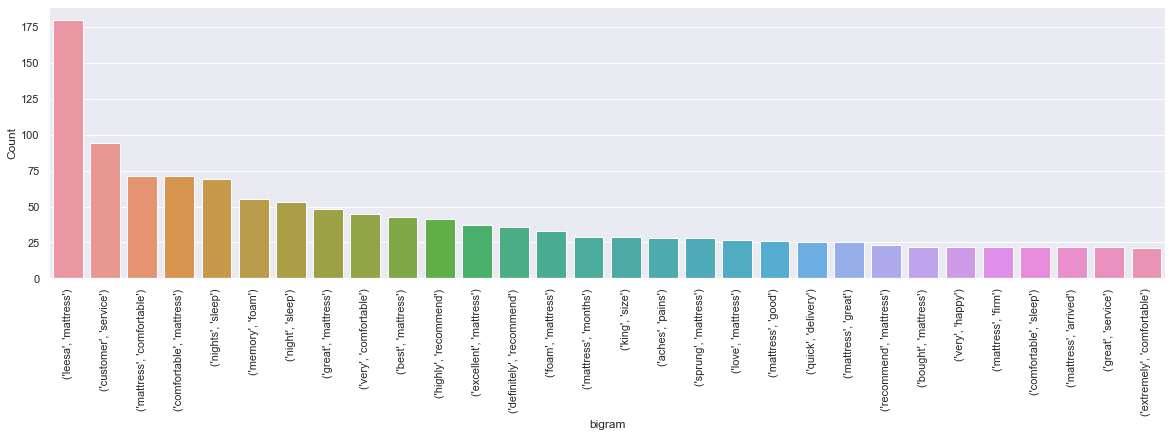

In [914]:
leesa_bigrams = get_bigrams(leesa_token)
freq_bigrams(leesa_bigrams)

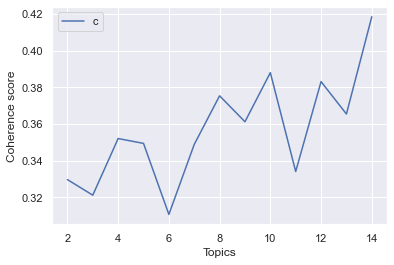

In [915]:
leesa_bad_reviews = leesa_sub[leesa_sub['Rating'].isin([1,2])]
leesa_bad_clean = clean_reviews(leesa_bad_reviews)
leesa_bad_token, leesa_bad_lemma = token_lemma(leesa_bad_clean)

#define values for LDA model
dictionary = corpora.Dictionary(leesa_bad_lemma)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in leesa_bad_lemma]

# Build LDA model with coherence values
leesa_bad_model_list, leesa_bad_coherence_values = compute_coherence_values(dictionary=dictionary, corpus =doc_term_matrix, texts=leesa_bad_lemma, limit=15, start=2, step=1)

# Plot results
limit=15
start=2
step=1
x=range(start,limit,step)
plt.plot(x,leesa_bad_coherence_values)
plt.xlabel('Topics')
plt.ylabel('Coherence score')
plt.legend(('coherence_values'), loc='best')
plt.show()

In [916]:
leesa_bad_LDA = get_LDA_vis(leesa_bad_lemma, 14)
leesa_bad_LDA

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11    -0.125232 -0.022348       1        1  17.629730
6      0.071194  0.040021       2        1  13.511661
13     0.050679  0.035772       3        1  11.673520
8      0.151112  0.095873       4        1   7.981330
5     -0.009666 -0.039712       5        1   7.799207
12    -0.019848 -0.051307       6        1   7.350554
1      0.042378 -0.202711       7        1   6.727354
9      0.056061  0.008990       8        1   6.095250
2      0.035280  0.011725       9        1   4.952915
4     -0.088065 -0.012950      10        1   4.811524
10    -0.151883  0.111336      11        1   4.324359
3      0.016279  0.009198      12        1   3.067183
0     -0.010501  0.031382      13        1   2.467521
7     -0.017786 -0.015269      14        1   1.607885, topic_info=         Term       Freq      Total Category  logprob  loglift
6       month  25.000000  25.000000  Default  30.0000  30.0000
4        give  14.000000  14.000000  Default  29.0000  29.0000
8    purchase  17.000000  17.000000  Default  28.0000  28.0000
16   mattress  99.000000  99.000000  Default  27.0000  27.0000
93       base   9.000000   9.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
340    people   0.030383   4.666566  Topic14  -7.1164  -0.9040
188     doesn   0.030383   3.656472  Topic14  -7.1164  -0.6601
230      fine   0.030383   3.467719  Topic14  -7.1164  -0.6071
253      feel   0.030383  10.416713  Topic14  -7.1164  -1.7070
76   question   0.030383   3.195964  Topic14  -7.1164  -0.5255

[775 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
744       5  0.678088   15stone
27        6  0.905912      20th
434       1  0.634488     abide
335       2  0.642854  absolute
494       2  0.642854    absorb
...     ...       ...       ...
26        3  0.170812      year
26        4  0.170812      year
26        5  0.113875      year
26        8  0.056937      year
26        9  0.056937      year

[1088 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 7, 14, 9, 6, 13, 2, 10, 3, 5, 11, 4, 1, 8])

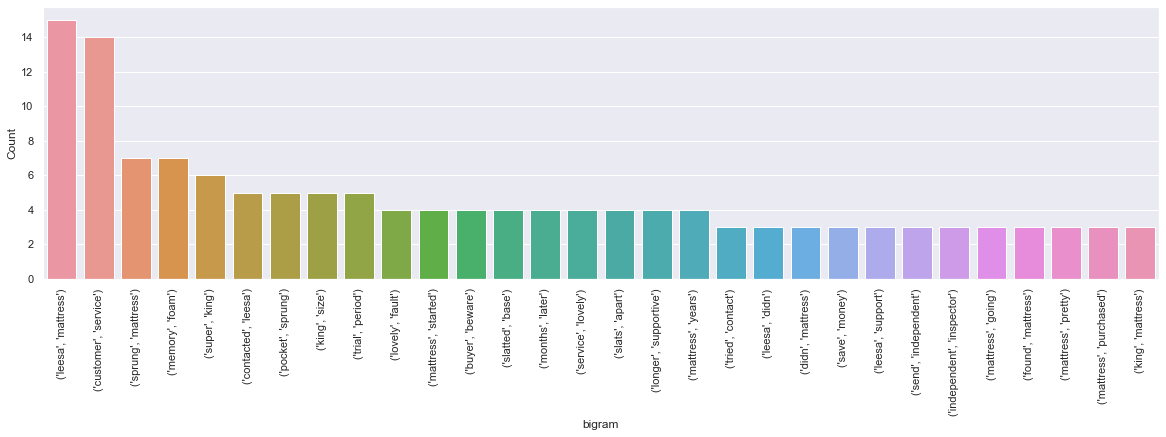

In [924]:
leesa_bad_bigrams = get_bigrams(leesa_bad_token)
freq_bigrams(leesa_bad_bigrams)

## Otty

In [917]:
otty_sub = subset('Otty')
otty_clean = clean_reviews(otty_sub)
otty_token, otty_lemma = token_lemma(otty_clean)
otty_LDA = get_LDA_vis(otty_lemma, 10)
otty_LDA

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.213485 -0.104479       1        1  23.337885
7      0.083880  0.171968       2        1  18.455427
9      0.234185 -0.117620       3        1  17.173481
3      0.208567 -0.008287       4        1   9.842306
1      0.008818 -0.087968       5        1   7.603056
0      0.056962  0.239360       6        1   7.037599
4     -0.165418  0.283240       7        1   6.326232
6     -0.151374 -0.210044       8        1   4.783462
2     -0.232674 -0.137179       9        1   3.595170
8     -0.256432 -0.028990      10        1   1.845378, topic_info=          Term         Freq        Total Category  logprob  loglift
3     delivery  2779.000000  2779.000000  Default  30.0000  30.0000
95      pillow  3547.000000  3547.000000  Default  29.0000  29.0000
22       sleep  2831.000000  2831.000000  Default  28.0000  28.0000
8      service  1629.000000  1629.000000  Default  27.0000  27.0000
90       night  1887.000000  1887.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
430       sale    97.022202   175.127777  Topic10  -3.0414   3.4019
185  fantastic    92.213242   251.042419  Topic10  -3.0922   2.9910
367      fault    45.395424   136.865952  Topic10  -3.8009   2.8889
112      thank    22.863771   316.738770  Topic10  -4.4867   1.3640
260    product    17.840345   490.842651  Topic10  -4.7348   0.6778

[525 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
743       3  0.140961      able
743       4  0.165836      able
743       5  0.688221      able
123       8  0.995846      ache
1143      9  0.988889       add
...     ...       ...       ...
361       1  0.996423      wrap
708       1  0.991233  wrapping
122       1  0.240188      year
122       3  0.760294      year
1555      3  0.954134         £

[641 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 8, 10, 4, 2, 1, 5, 7, 3, 9])

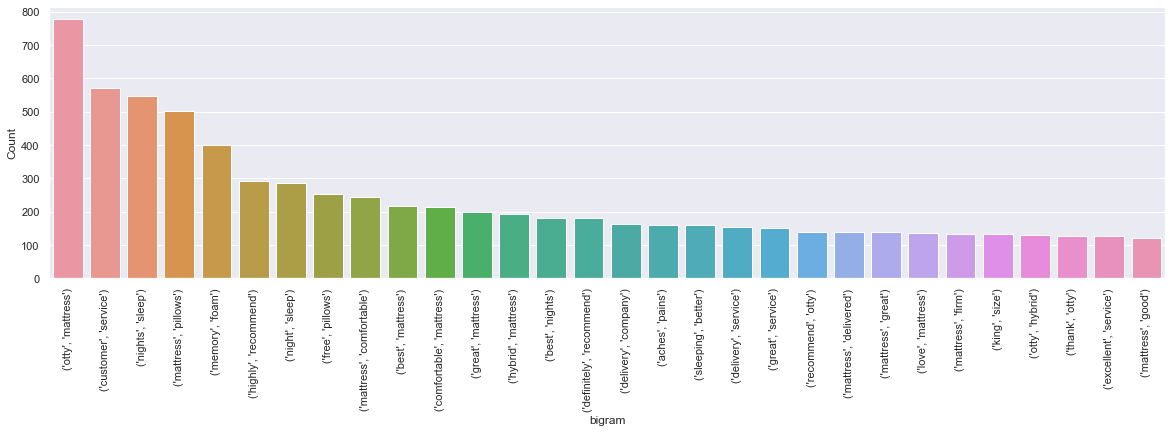

In [918]:
otty_bigrams = get_bigrams(otty_token)
freq_bigrams(otty_bigrams)

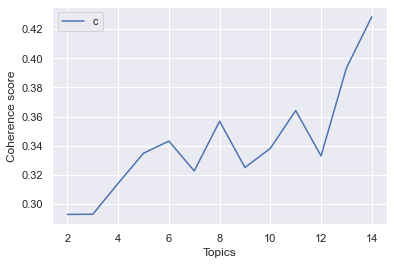

In [919]:
otty_bad_reviews = otty_sub[otty_sub['Rating'].isin([1,2])]
otty_bad_clean = clean_reviews(otty_bad_reviews)
otty_bad_token, otty_bad_lemma = token_lemma(otty_bad_clean)

#define values for LDA model
dictionary = corpora.Dictionary(otty_bad_lemma)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in otty_bad_lemma]

# Build LDA model with coherence values
otty_bad_model_list, otty_bad_coherence_values = compute_coherence_values(dictionary=dictionary, corpus =doc_term_matrix, texts=otty_bad_lemma, limit=15, start=2, step=1)

# Plot results
limit=15
start=2
step=1
x=range(start,limit,step)
plt.plot(x,otty_bad_coherence_values)
plt.xlabel('Topics')
plt.ylabel('Coherence score')
plt.legend(('coherence_values'), loc='best')
plt.show()

In [922]:
otty_bad_LDA = get_LDA_vis(otty_bad_lemma, 14)
otty_bad_LDA

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12     0.284858  0.041345       1        1  63.719643
5      0.209185  0.073917       2        1   9.436852
11     0.203951  0.081721       3        1   7.131048
2      0.182721 -0.062068       4        1   6.237867
0      0.055770 -0.263362       5        1   4.800796
1     -0.097729 -0.008523       6        1   1.638576
8     -0.143512  0.097443       7        1   1.464727
10    -0.086344 -0.043909       8        1   1.286038
4     -0.119367  0.019826       9        1   1.217010
13    -0.115584  0.001007      10        1   1.016767
3     -0.096108  0.022747      11        1   0.883596
6     -0.095430  0.014816      12        1   0.462015
9     -0.098632  0.022695      13        1   0.399769
7     -0.083778  0.002344      14        1   0.305295, topic_info=          Term        Freq       Total Category  logprob  loglift
27    mattress  431.000000  431.000000  Default  30.0000  30.0000
8      service  276.000000  276.000000  Default  29.0000  29.0000
1     customer  265.000000  265.000000  Default  28.0000  28.0000
82      return  119.000000  119.000000  Default  27.0000  27.0000
106      email  176.000000  176.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
1959  blocking    0.017753    0.639296  Topic14  -7.7933   2.2078
1956   barrier    0.017836    0.646590  Topic14  -7.7886   2.2012
1975  language    0.017836    0.646590  Topic14  -7.7886   2.2012
1961   british    0.017836    0.646590  Topic14  -7.7886   2.2012
1954    ashame    0.017753    0.639296  Topic14  -7.7933   2.2078

[788 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
1747      8  0.588565  03pm
1496      2  0.854136  14th
378       3  0.553460  18th
378       9  0.276730  18th
1748      8  0.588565  28pm
...     ...       ...   ...
71        2  0.058059  year
71        5  0.290296  year
71        6  0.058059  year
71        8  0.522533  year
71        9  0.058059  year

[885 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 6, 12, 3, 1, 2, 9, 11, 5, 14, 4, 7, 10, 8])

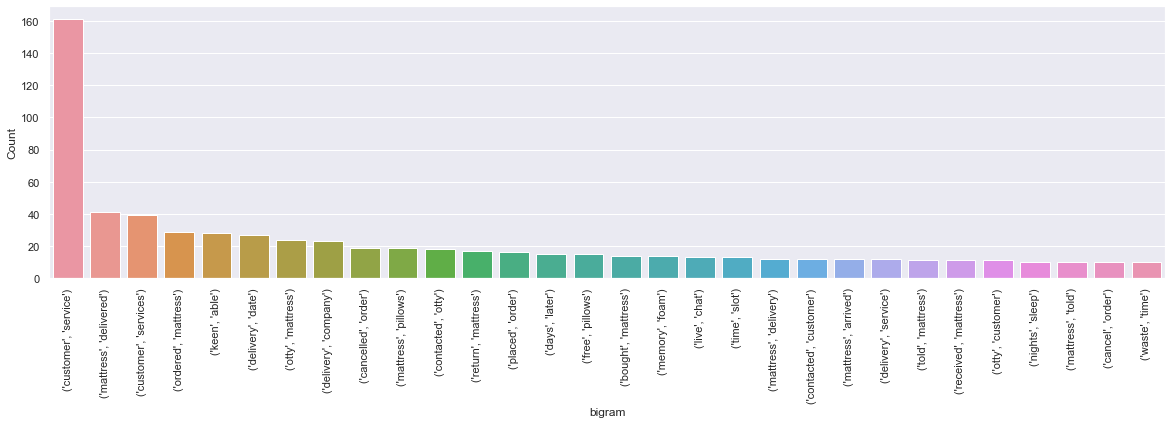

In [925]:
otty_bad_bigrams = get_bigrams(otty_bad_token)
freq_bigrams(otty_bad_bigrams)

## Eve

In [920]:
eve_sub = subset('Eve')
eve_clean = clean_reviews(eve_sub)
eve_token, eve_lemma = token_lemma(eve_clean)
eve_LDA = get_LDA_vis(eve_lemma, 10)
eve_LDA

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.212616  0.040280       1        1  26.824987
7      0.145683 -0.190645       2        1  15.624902
8     -0.052176 -0.269800       3        1  12.951167
0      0.225517  0.111251       4        1  11.266332
5      0.032866  0.113974       5        1  10.019023
6      0.237201  0.051338       6        1   8.010512
9     -0.192792 -0.009946       7        1   5.101138
1     -0.196580  0.187325       8        1   4.745110
4     -0.235631  0.117797       9        1   2.927633
2     -0.176704 -0.151575      10        1   2.529191, topic_info=         Term         Freq        Total Category  logprob  loglift
19      sleep  2867.000000  2867.000000  Default  30.0000  30.0000
111   service  1189.000000  1189.000000  Default  29.0000  29.0000
124     night  1501.000000  1501.000000  Default  28.0000  28.0000
75   customer   730.000000   730.000000  Default  27.0000  27.0000
4       great  1172.000000  1172.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
75   customer   533.316101   730.527710  Topic10  -1.3885   3.3626
111   service   545.828979  1189.399048  Topic10  -1.3653   2.8984
292    second    40.962067    98.792892  Topic10  -3.9550   2.7969
4       great   217.525452  1172.366333  Topic10  -2.2853   1.9928
852         👍     5.113737    12.592348  Topic10  -6.0357   2.7761

[496 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
610       9  0.963375   absolute
277       4  0.997983       ache
3120      6  0.957812  advantage
1104      9  0.979427  advertise
712       5  0.988863     advise
...     ...       ...        ...
28        5  0.360418       year
28        6  0.222730       year
2107     10  0.772971          🏻
852       1  0.555893          👍
852      10  0.397067          👍

[583 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 8, 9, 1, 6, 7, 10, 2, 5, 3])

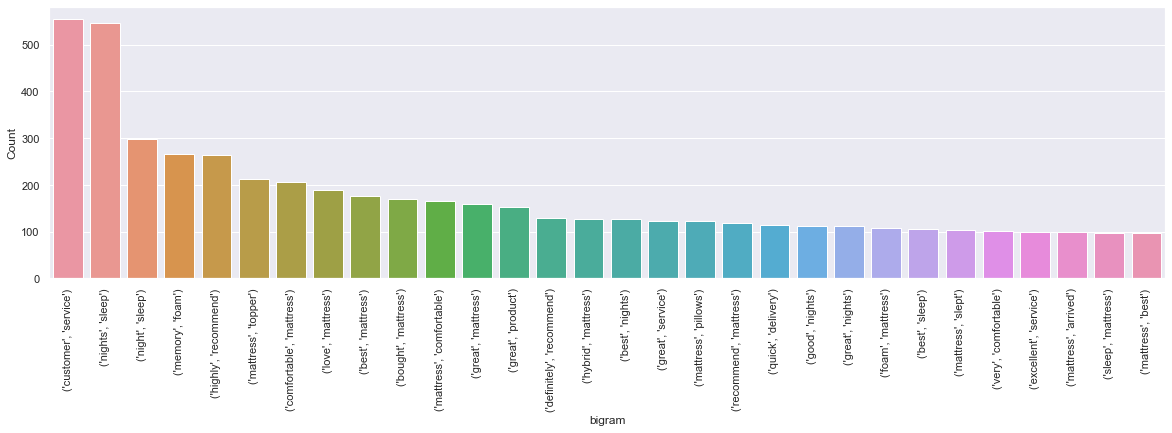

In [921]:
eve_bigrams = get_bigrams(eve_token)
freq_bigrams(eve_bigrams)

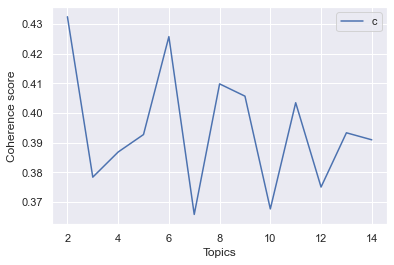

In [923]:
eve_bad_reviews = eve_sub[eve_sub['Rating'].isin([1,2])]
eve_bad_clean = clean_reviews(eve_bad_reviews)
eve_bad_token, eve_bad_lemma = token_lemma(eve_bad_clean)

#define values for LDA model
dictionary = corpora.Dictionary(eve_bad_lemma)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in eve_bad_lemma]

# Build LDA model with coherence values
eve_bad_model_list, eve_bad_coherence_values = compute_coherence_values(dictionary=dictionary, corpus =doc_term_matrix, texts=eve_bad_lemma, limit=15, start=2, step=1)

# Plot results
limit=15
start=2
step=1
x=range(start,limit,step)
plt.plot(x,eve_bad_coherence_values)
plt.xlabel('Topics')
plt.ylabel('Coherence score')
plt.legend(('coherence_values'), loc='best')
plt.show()

In [927]:
eve_bad_LDA = get_LDA_vis(eve_bad_lemma, 2)
eve_bad_LDA

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.102813  0.0       1        1  51.125263
1     -0.102813  0.0       2        1  48.874741, topic_info=         Term        Freq       Total Category  logprob  loglift
10   delivery  216.000000  216.000000  Default  30.0000  30.0000
84      order  163.000000  163.000000  Default  29.0000  29.0000
297      year  117.000000  117.000000  Default  28.0000  28.0000
131   deliver  103.000000  103.000000  Default  27.0000  27.0000
11      email  130.000000  130.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
106    return   43.443348   78.268829   Topic2  -5.1469   0.1272
33       send   52.225353  120.624084   Topic2  -4.9628  -0.1212
50       come   37.536850   73.477127   Topic2  -5.2931   0.0443
116        go   35.634209   64.881683   Topic2  -5.3451   0.1167
181   product   36.673717   83.626343   Topic2  -5.3163  -0.1084

[149 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
0         1  0.044553  answer
0         2  0.935607  answer
548       1  0.994469    area
1         1  0.092265  arrive
1         2  0.922654  arrive
...     ...       ...     ...
296       1  0.935029    wife
296       2  0.062335    wife
43        1  0.147862    work
43        2  0.844926    work
297       1  0.997572    year

[177 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

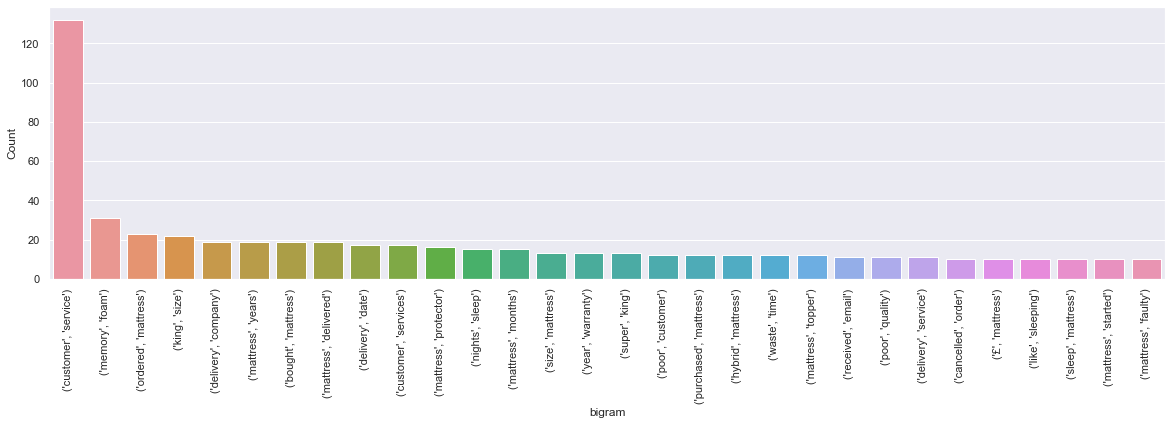

In [926]:
eve_bad_bigrams = get_bigrams(eve_bad_token)
freq_bigrams(eve_bad_bigrams)

# Conclusions
Here we set out to look at online mattress companies and specifically the customer feedback on the companies. We started by scraping data from trustpilot using BeuatifulSoup and ended up with 46,719 reviews. We took a look at the average ratings of each company and over time there seems to be a near universal downward trend. Emma appears to currently have a slight upwards trajectory, but this could be short-lived given that compared to early 2018 the average hasn't really moved.

We proceeded to analyze the reviews themselves and attempted to identify topics cropping up in the data. Here's a few key points from this analysis:

- Simba and Eve have been around the longest, but also maintain the best average reviews;

- All companies are struggling with negative reviews around their customer service and deliveries;
- Otty, Casper and Emma seem to have mattresses with a strong smell - not ideal; 
- Other negative reviews mention the fact that mattresses are too soft or too hard, this will always be a problem if there's no try before you buy, since customers will inevitably have different preferences.

This analysis is really just the beginning of what needs to be done for a full analysis, which brings us to other additions.

## Future Additions
- We noted for Casper that some reviews were in French and German. Here we could use the python googletrans API to convert everything to English so that we can combine pain points more effectively;
- Something like the current analysis could be combined with real time review data in order to identify emerging trends;
- Also for new reviews, we could create a sentiment analysis tool. These additions may actually be useful to help integrate feedback from social media where 'star reviews' aren't shown.

Some other minor points:

- We should remove some keywords from the dictionary, things like company names and 'mattress' may actually skew the results since these words almost always showed up with overwhelming frequency;
- As a secondary point, many of these companies sell a variety of products and we could separate reviews for mattresses and pillows and duvets etc. so as to get a better specificity of review if we're just interested in say, mattresses.
- For the optimal topic numbers for each model, there are several other ways to do this, it would be interesting to compare methods;
- The LDA models could be made more complex by optimizing the alpha and beta hyperparameters;
- We could make some word clouds from the topics, that might be a nice visualization;
- The bigrams were only used here to get in idea of context, but we could also look at other ngrams and perhaps incorporate these into the topic modelling.

